# Executive Summary

I'm using the environment in the OpenAI gym - Classic Control to practice how to train an agent by reinforcement learning. In this notebook, a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track and ***the goal is to prevent it from falling over.***

I try differnet methods to complete this goal:

***1. Create a simple policy (without any learning applied)*** (See Section 4)
- By using a simple policy ***the score in between 134 to 235 (average 181) prevent it from falling over*** 
- I tried choosing action by monitoring all four observations (Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity) in the simple policy, ***choosing action by monitoring the Pole Angular Velocity has the best score***.

***2. Create a Deep Learning Neural Network with Keras*** (See Section 5)
- The agent received ***all perfect scores to prevent the Pole from falling over*** 
- the log on the above showing that we may ***reduce number of learning timesteps to 40000***, because the agent start received 500 episode reward start in the 36220 episode consistently.

***3. Epsilon-Greedy Policy*** (See Section 6-7)
- The learning process with ***Epsilon-Greedy Policy reach perfect score at epoch #31*** (time spend: learning 6min).

***4. Deep Crossentropy Method (Monte Carlo Method)*** (See Section 8)
- ***Mean reward reach 499 at around 25 sessions***. (Time spend: 2 min 43s)

***5. Actor Critic NetWork*** (See Section 9)
- The ***Actor Critic Network with 2 fully conneted layers***, it reach ***highest performance in episode 8437 with score 364*** and ***avgerage score 335.9***. (Time spend 9h 45min)


### ***Table of Content:***

1. What is CartPole
2. Import Dependencies
3. Understanding The Environment
4. Create a Simple Policy (without any Learning to Comlete the Goal)
5. Create a Deep Learning Neural Network with Keras
   - 5.1 Build Agent with Keras-RL
   - 5.2 Train the Agents
6. Epsilon-Greedy Policy
7. Q-learning via Gradient Descent
8. Deep Crossentropy Method (Monte Carlo Method)
9. Actor Critic NetWork

# 1. What is CartPole?

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and ***the goal is to prevent it from falling over***. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

### Action Space
- The agent take a 1-element vector for actions.
- The action space is `(action)` in `[0, 1]`, where `action` is used to push the cart with a fixed amount of force:


 Num | Action                 |
-----|------------------------|
 0   | Push cart to the left  |
 1   | Push cart to the right |
 
### Observation Space
The observation is a `ndarray` with shape `(4,)` where the elements correspond to the following:

 Num | Observation           | Min                   | Max                 |
-----|-----------------------|-----------------------|---------------------|
 0   | Cart Position         | -4.8*                 | 4.8*                |
 1   | Cart Velocity         | -Inf                  | Inf                 |
 2   | Pole Angle            | ~ -0.418 rad (-24°)** | ~ 0.418 rad (24°)** |
 3   | Pole Angular Velocity | -Inf                  | Inf                 |
 
### Rewards
Reward is 1 for every step taken, including the termination step. The threshold is 475 for v1.

# 2. Import Dependencies

2022-04-24 12:33:59.778 python[14044:576384] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f949b118410>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-24 12:33:59.779 python[14044:576384] Warning: Expected min height of view: (<NSButton: 0x7f94ac9bf5a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-24 12:33:59.782 python[14044:576384] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f94ac9bfd00>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-24 12:33:59.784 python[14044:576384] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f94ac9c2910>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action space: Discrete(2)


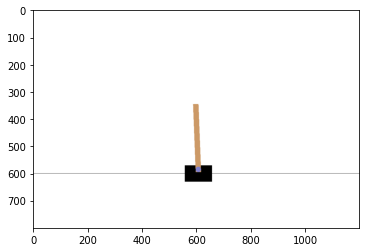

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("CartPole-v1")                          # Using CartPole verion 1 in this notebook
env.reset()                                            # reset the environment to initial default

plt.imshow(env.render('rgb_array'))                    # display the environment
print("Observation space:", env.observation_space)     # ndarray with shape (4,)
print("Action space:", env.action_space)               # 2 actions could be taken in this environment: Push cart to the left, Push cart to the right

In [3]:
env.close

<bound method Wrapper.close of <TimeLimit<CartPoleEnv<CartPole-v1>>>>

# 3. Understanding The Environment

In [4]:
obs = env.reset()
print("initial observation code:", obs)

# Note: in CartPole, observation is just 4 numbers: Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity	

initial observation code: [-0.03156997 -0.00446322 -0.00202517 -0.04993391]


In [5]:
# If an action 2: acelerate to right is given into the environment
new_obs, reward, is_done, _ = env.step(1)

print("taking action 2 (right)")

# Then the environment will reply 3 things new_observation, reward and is_done to the agent
print("new observation code:", new_obs)
print("reward:", reward)
print("is game over?:", is_done)

# Note: the car has moved to the right slightly (from -0.4775 to -0.4769 around 0.001 moved to right)

taking action 2 (right)
new observation code: [-0.03165924  0.19068772 -0.00302385 -0.3432551 ]
reward: 1.0
is game over?: False


### Project Baseline Use Random Action

In [8]:
%%time
episodes = 5

for episode in range(1, episodes + 1):                     # looping from 1 to 5
    
    obs = env.reset()                                      # initial the set of observation
    
    done = False                                           # initial the game is over = False, until reach maximum number of steps in this particular environment
    
    score = 0                                              # running score counter
    
    timesteps_counter = 0                                  # count the number of timestep spend
    
    while not done:
        
        env.render()                                       # view the graphical representation that environment
        
        action = env.action_space.sample()                 # random choose an action 
        
        n_obs, reward, done, info = env.step(action)       # pass random actions into environment to get back
                                                            # 1. next set of observation (4 observation in this case)
                                                            # 2. reward is 1 for every step taken
                                                            # 3. done (episode is done = True)
        
        score += reward                                    # accumulate each episodes' reward received into score
        
        timesteps_counter += 1                             # +1 in each timestep spend
        
    print('Episode:{} Score:{} Timesteps Spend:{}'.format(episode, score,timesteps_counter))    # print out score for each episode

Episode:1 Score:27.0 Timesteps Spend:27
Episode:2 Score:41.0 Timesteps Spend:41
Episode:3 Score:10.0 Timesteps Spend:10
Episode:4 Score:17.0 Timesteps Spend:17
Episode:5 Score:20.0 Timesteps Spend:20
CPU times: user 52.5 ms, sys: 17.5 ms, total: 70.1 ms
Wall time: 89.8 ms


Remark: 
- The above 5 episode showing that, ***the score in between 10 to 41 (average 23) prevent it from falling over*** 

# 4. Create a Simple Policy (without any Learning to Comlete the Goal)

So, now let's create a simply policy (without any learning) to prevent it from falling over.

Note: in CartPole, observation is just 4 numbers: Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity	

In [6]:
# Define 3 actions as Dictionary
actions = {'Push cart to the left': 0, 'Push cart to the right': 1}      

# Define a policy
def simple_policy(obs):
    
    position, cart_velocity, angle, pole_velocity = obs        # observe current postion and velocity

    if pole_velocity < 0:                                      # if current velocity is positive
        return actions['Push cart to the left']                # the policy return an actions 'Push cart to the left' 

    if pole_velocity > 0:                                      # if current velocity is negative
        return actions['Push cart to the right']               # the policy choose an actions 'Push cart to the right'

### Evaluate the Simple Policy

In [35]:
%%time
episodes = 5

for episode in range(1, episodes + 1):                     # looping from 1 to 5
    
    obs = env.reset()                                      # initial the set of observation
    
    done = False                                           # initial the game is over = False, until reach maximum number of steps in this particular environment
    
    score = 0                                              # running score counter
    
    timesteps_counter = 0                                  # count the number of timestep spend
    
    while not done:
        
        env.render()                                       # view the graphical representation that environment
        
        action = simple_policy(obs)                        # random choose an action 
        
        obs, reward, done, info = env.step(action)       # pass random actions into environment to get back
                                                            # 1. next set of observation (4 observation in this case)
                                                            # 2. reward (Positive value increment, negative value decrement)
                                                            # 3. done (episode is done = True)
        
        score += reward                                    # accumulate each episodes' reward received into score
        
        timesteps_counter += 1                             # +1 in each timestep spend
        
    print('Episode:{} Score:{} Timesteps Spend:{}'.format(episode, score,timesteps_counter))    # print out score for each episode

Episode:1 Score:185.0 Timesteps Spend:185
Episode:2 Score:235.0 Timesteps Spend:235
Episode:3 Score:193.0 Timesteps Spend:193
Episode:4 Score:134.0 Timesteps Spend:134
Episode:5 Score:159.0 Timesteps Spend:159
CPU times: user 305 ms, sys: 90.7 ms, total: 395 ms
Wall time: 469 ms


Remark: 
- The above 5 episode showing that, by using a simple policy ***the score in between 134 to 235 (average 181) prevent it from falling over*** 
- I tried choosing action by monitoring all four observations (Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity) in the simple policy, ***choosing action by monitoring the Pole Angular Velocity has the best score***.

# 5. Create a Deep Learning Neural Network with Keras

In [7]:
# Import Dependencies
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Build a Sequential Model
def build_network(states, actions):
    
    network = Sequential()
    
    network.add(Convolution2D(16,                                # For image base model, we start with convolution2D layer with 32 convolution2D filters 
                            (8,8),                                      # Filter size 8 x 8
                            strides = (4,4),                            # 4 x 4 means move 4 pixels to the right, and then 4 pixels to downward
                            activation = 'relu',                        # use 'relu' function
                            input_shape = (3, height, width, channels)  # pass through the image's heights, width, and channels as input into the model
                           ))
    
    network.add(Convolution2D(32,                                # 64 convolution2D filters in the second layer
                            (4,4),                                      # Filter size 4 x 4
                            strides = (2,2),                            # 2 x 2 means move 2 pixels to the right, and then 2 pixels to downward
                            activation = 'relu'
                           ))
    
    network.add(Flatten())                                                # use Flatten layer as the input layer, input_shape = 1 x number of state 
    
    #network.add(Dense(512, activation = 'relu', name = 'Dense_1'))        # use Dense layer with 512 units of tensor with relu activation function
    
    network.add(Dense(256, activation = 'relu', name = 'Dense_2'))        # use another Dense layer with 256 units of tensor with relu activation function
    
    network.add(Dense(actions, activation = 'linear', name = 'Actions'))  # the output layer with shape = number of actions with linear activation function
                                                                           # Output the probability for each actions 
    
    return network                                                        # build_model return a model

In [14]:
# Import Dependencies
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Build a Sequential Model
def build_network(states, actions):
    
    network = Sequential()
    
    network.add(Flatten(input_shape = (1, states), name = 'States'))      # use Flatten layer as the input layer, input_shape = 1 x number of state 
    
    network.add(Dense(512, activation = 'relu', name = 'Dense_1'))        # use Dense layer with 512 units of tensor with relu activation function
    
    network.add(Dense(256, activation = 'relu', name = 'Dense_2'))        # use another Dense layer with 256 units of tensor with relu activation function
    
    network.add(Dense(actions, activation = 'linear', name = 'Actions'))  # the output layer with shape = number of actions with linear activation function
                                                                           # Output the probability for each actions 
    
    return network                                                        # build_model return a model

In [46]:
del network

In [15]:
# Set the input_shape of the build_model function
states = env.observation_space.shape[0]                         # use .shape[0] to return number of observation space

# Set the output_shape of the build_model function
actions = env.action_space.n                                    # use .n to return number of action

# Run the build_model function to build the model
network = build_network(states, actions)                            

# See the model summary
network.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 States (Flatten)            (None, 4)                 0         
                                                                 
 Dense_1 (Dense)             (None, 512)               2560      
                                                                 
 Dense_2 (Dense)             (None, 256)               131328    
                                                                 
 Actions (Dense)             (None, 2)                 514       
                                                                 
Total params: 134,402
Trainable params: 134,402
Non-trainable params: 0
_________________________________________________________________


# 5.1 Build Agent with Keras-RL

In [16]:
# Import Dependencies
from rl.agents import DQNAgent                                                      # used DQNAgent here, should try other agents: SARSAAgent      
from rl.policy import BoltzmannQPolicy, LinearAnnealedPolicy, EpsGreedyQPolicy      # used Policy base RL  
from rl.memory import SequentialMemory
import os

# Build an Agent to learn from the model
def build_agent(model, actions):            
    
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(),    # use EpsGreedyQPolicy()
                                  attr='eps',
                                  value_max = 1,
                                  value_min = .1,
                                  value_test = 0.2,
                                  nb_steps = 10000
    )                    

    memory = SequentialMemory(limit = 1000,              # buffer limit: number of episode
                              window_length = 1          # store pass 1 window for 1000 episode 
                             )
    
    dqn = DQNAgent(model = model, 
                   memory = memory,
                   policy = policy,
                   enable_dueling_network = True,        # Dueling Networks split value and advantage, help the model learn when to take action and when not to bother
                   dueling_type = 'avg',
                   nb_actions = actions,                 # 3 actions to learn
                   nb_steps_warmup = 1000,           
                   target_model_update = 1e-2
                  )
    
    return dqn

# 5.2 Train the Agent

In [49]:
# set the path to save the log
log_path = os.path.join("Training", "Logs", "CartPole-v1_Keras-RL")

In [52]:
%%time
# run the build_agent function to traing the agent
agent = build_agent(network, actions)                      # used build_agent to setup a dqn model

agent.compile(Adam(learning_rate = 1e-4),                # use Adam optimisation with learning rate 0.0001
            metrics = ['mae']                            # use mean absolute error to evaluate the metric
           )      

history = agent.fit(env, 
        nb_steps = 500000,                               # number of timesteps 
        visualize = False,                               # visualize during the training
        verbose = 2                                      # how to show the training output
       )

Training for 500000 steps ...
     15/500000: episode: 1, duration: 0.070s, episode steps:  15, steps per second: 215, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: --, mae: --, mean_q: --, mean_eps: --
     45/500000: episode: 2, duration: 0.014s, episode steps:  30, steps per second: 2086, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: --, mae: --, mean_q: --, mean_eps: --
     78/500000: episode: 3, duration: 0.015s, episode steps:  33, steps per second: 2226, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: --, mae: --, mean_q: --, mean_eps: --
     90/500000: episode: 4, duration: 0.006s, episode steps:  12, steps per second: 2087, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.833 [0.000, 1.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    105/500000: episode: 5, duration: 0.007

/Users/hoikinyu/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


    304/500000: episode: 14, duration: 0.009s, episode steps:  19, steps per second: 2036, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.632 [0.000, 1.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    321/500000: episode: 15, duration: 0.009s, episode steps:  17, steps per second: 1903, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.706 [0.000, 1.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    332/500000: episode: 16, duration: 0.006s, episode steps:  11, steps per second: 1851, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.273 [0.000, 1.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    357/500000: episode: 17, duration: 0.011s, episode steps:  25, steps per second: 2207, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    373/500000: episode: 18, duration: 0.008s, episode steps:  16, s

/Users/hoikinyu/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


   1017/500000: episode: 49, duration: 0.522s, episode steps:  26, steps per second:  50, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462 [0.000, 1.000],  loss: 16.887636, mae: 4.696716, mean_q: 8.960082, mean_eps: 0.909235
   1032/500000: episode: 50, duration: 0.076s, episode steps:  15, steps per second: 197, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: 8.867466, mae: 4.665575, mean_q: 9.450425, mean_eps: 0.907840
   1046/500000: episode: 51, duration: 0.066s, episode steps:  14, steps per second: 211, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357 [0.000, 1.000],  loss: 5.168766, mae: 5.049514, mean_q: 9.781283, mean_eps: 0.906535
   1061/500000: episode: 52, duration: 0.074s, episode steps:  15, steps per second: 203, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.267 [0.000, 1.000],  loss: 2.697559, mae: 5.071849, mean_q: 9.96

   2095/500000: episode: 83, duration: 0.167s, episode steps:  35, steps per second: 210, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.543 [0.000, 1.000],  loss: 0.823913, mae: 8.260288, mean_q: 16.602191, mean_eps: 0.813070
   2139/500000: episode: 84, duration: 0.209s, episode steps:  44, steps per second: 211, episode reward: 44.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 [0.000, 1.000],  loss: 1.011767, mae: 8.403628, mean_q: 16.922491, mean_eps: 0.809515
   2194/500000: episode: 85, duration: 0.259s, episode steps:  55, steps per second: 212, episode reward: 55.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: 1.035371, mae: 8.638543, mean_q: 17.356946, mean_eps: 0.805060
   2228/500000: episode: 86, duration: 0.159s, episode steps:  34, steps per second: 214, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.441 [0.000, 1.000],  loss: 0.924543, mae: 8.774709, mean_q: 17

   3576/500000: episode: 116, duration: 0.102s, episode steps:  21, steps per second: 205, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.476 [0.000, 1.000],  loss: 1.836663, mae: 14.576106, mean_q: 29.770343, mean_eps: 0.679150
   3600/500000: episode: 117, duration: 0.117s, episode steps:  24, steps per second: 204, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.458 [0.000, 1.000],  loss: 2.582568, mae: 14.727703, mean_q: 30.112892, mean_eps: 0.677125
   3632/500000: episode: 118, duration: 0.153s, episode steps:  32, steps per second: 210, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.438 [0.000, 1.000],  loss: 2.703619, mae: 14.882109, mean_q: 30.357943, mean_eps: 0.674605
   3661/500000: episode: 119, duration: 0.132s, episode steps:  29, steps per second: 220, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.448 [0.000, 1.000],  loss: 2.663419, mae: 15.108057, me

   6713/500000: episode: 148, duration: 1.063s, episode steps: 216, steps per second: 203, episode reward: 216.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.523 [0.000, 1.000],  loss: 1.464353, mae: 25.009956, mean_q: 50.726705, mean_eps: 0.405595
   6836/500000: episode: 149, duration: 0.588s, episode steps: 123, steps per second: 209, episode reward: 123.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.512 [0.000, 1.000],  loss: 1.106099, mae: 25.155809, mean_q: 51.020592, mean_eps: 0.390340
   7036/500000: episode: 150, duration: 0.949s, episode steps: 200, steps per second: 211, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: 1.226385, mae: 25.107759, mean_q: 50.760701, mean_eps: 0.375805
   7213/500000: episode: 151, duration: 0.808s, episode steps: 177, steps per second: 219, episode reward: 177.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.525 [0.000, 1.000],  loss: 0.819000, mae: 24.572307

  12907/500000: episode: 180, duration: 1.007s, episode steps: 222, steps per second: 221, episode reward: 222.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.518 [0.000, 1.000],  loss: 0.011046, mae: 30.440739, mean_q: 61.141921, mean_eps: 0.100000
  13139/500000: episode: 181, duration: 1.175s, episode steps: 232, steps per second: 197, episode reward: 232.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.513 [0.000, 1.000],  loss: 0.009320, mae: 30.820974, mean_q: 61.874678, mean_eps: 0.100000
  13393/500000: episode: 182, duration: 1.320s, episode steps: 254, steps per second: 192, episode reward: 254.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.512 [0.000, 1.000],  loss: 0.009719, mae: 30.999265, mean_q: 62.196512, mean_eps: 0.100000
  13628/500000: episode: 183, duration: 1.085s, episode steps: 235, steps per second: 217, episode reward: 235.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.515 [0.000, 1.000],  loss: 0.007232, mae: 30.622329

  20861/500000: episode: 212, duration: 0.975s, episode steps: 199, steps per second: 204, episode reward: 199.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.487 [0.000, 1.000],  loss: 2.827188, mae: 40.468924, mean_q: 81.056425, mean_eps: 0.100000
  21075/500000: episode: 213, duration: 1.116s, episode steps: 214, steps per second: 192, episode reward: 214.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 1.000],  loss: 3.173036, mae: 40.337797, mean_q: 80.776400, mean_eps: 0.100000
  21277/500000: episode: 214, duration: 0.978s, episode steps: 202, steps per second: 207, episode reward: 202.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.485 [0.000, 1.000],  loss: 3.787800, mae: 40.408827, mean_q: 80.757304, mean_eps: 0.100000
  21459/500000: episode: 215, duration: 0.988s, episode steps: 182, steps per second: 184, episode reward: 182.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.484 [0.000, 1.000],  loss: 2.443058, mae: 40.379050

  29331/500000: episode: 244, duration: 1.577s, episode steps: 354, steps per second: 225, episode reward: 354.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.492 [0.000, 1.000],  loss: 0.028059, mae: 39.074819, mean_q: 78.298890, mean_eps: 0.100000
  29659/500000: episode: 245, duration: 1.507s, episode steps: 328, steps per second: 218, episode reward: 328.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.485 [0.000, 1.000],  loss: 0.042834, mae: 38.549682, mean_q: 77.208909, mean_eps: 0.100000
  29993/500000: episode: 246, duration: 1.627s, episode steps: 334, steps per second: 205, episode reward: 334.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.485 [0.000, 1.000],  loss: 0.025065, mae: 39.117879, mean_q: 78.353836, mean_eps: 0.100000
  30334/500000: episode: 247, duration: 1.683s, episode steps: 341, steps per second: 203, episode reward: 341.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.490 [0.000, 1.000],  loss: 0.021773, mae: 38.599070

  41837/500000: episode: 276, duration: 2.239s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 0.027660, mae: 42.644245, mean_q: 85.451531, mean_eps: 0.100000
  42337/500000: episode: 277, duration: 2.273s, episode steps: 500, steps per second: 220, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 3.497746, mae: 46.663404, mean_q: 93.273722, mean_eps: 0.100000
  42837/500000: episode: 278, duration: 2.323s, episode steps: 500, steps per second: 215, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.426369, mae: 50.356322, mean_q: 100.514013, mean_eps: 0.100000
  43337/500000: episode: 279, duration: 2.326s, episode steps: 500, steps per second: 215, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 11.681182, mae: 51.1364

  54071/500000: episode: 308, duration: 2.408s, episode steps: 500, steps per second: 208, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.263963, mae: 49.613125, mean_q: 99.391540, mean_eps: 0.100000
  54571/500000: episode: 309, duration: 2.400s, episode steps: 500, steps per second: 208, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.685316, mae: 46.940982, mean_q: 93.961969, mean_eps: 0.100000
  55071/500000: episode: 310, duration: 2.323s, episode steps: 500, steps per second: 215, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.290096, mae: 45.275020, mean_q: 90.542647, mean_eps: 0.100000
  55571/500000: episode: 311, duration: 2.487s, episode steps: 500, steps per second: 201, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.912971, mae: 45.204767

  69372/500000: episode: 340, duration: 1.206s, episode steps: 270, steps per second: 224, episode reward: 270.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.507 [0.000, 1.000],  loss: 8.391257, mae: 45.915764, mean_q: 91.805935, mean_eps: 0.100000
  69749/500000: episode: 341, duration: 1.782s, episode steps: 377, steps per second: 212, episode reward: 377.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.504 [0.000, 1.000],  loss: 5.471382, mae: 42.298916, mean_q: 84.736367, mean_eps: 0.100000
  70249/500000: episode: 342, duration: 2.447s, episode steps: 500, steps per second: 204, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 0.682816, mae: 40.223379, mean_q: 80.915358, mean_eps: 0.100000
  70749/500000: episode: 343, duration: 2.465s, episode steps: 500, steps per second: 203, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 1.744609, mae: 43.876250

  85249/500000: episode: 372, duration: 2.461s, episode steps: 500, steps per second: 203, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 12.187153, mae: 48.911267, mean_q: 97.684798, mean_eps: 0.100000
  85749/500000: episode: 373, duration: 2.470s, episode steps: 500, steps per second: 202, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.588918, mae: 44.532834, mean_q: 88.982927, mean_eps: 0.100000
  86249/500000: episode: 374, duration: 2.417s, episode steps: 500, steps per second: 207, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 6.706586, mae: 43.946036, mean_q: 87.723079, mean_eps: 0.100000
  86749/500000: episode: 375, duration: 2.445s, episode steps: 500, steps per second: 205, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [0.000, 1.000],  loss: 7.551957, mae: 46.16675

 100586/500000: episode: 407, duration: 0.059s, episode steps:  10, steps per second: 170, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.700 [0.000, 1.000],  loss: 34.197634, mae: 47.741802, mean_q: 94.697960, mean_eps: 0.100000
 101086/500000: episode: 408, duration: 2.468s, episode steps: 500, steps per second: 203, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 13.175072, mae: 46.815515, mean_q: 93.384061, mean_eps: 0.100000
 101524/500000: episode: 409, duration: 2.151s, episode steps: 438, steps per second: 204, episode reward: 438.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.505 [0.000, 1.000],  loss: 8.886299, mae: 46.943006, mean_q: 94.012290, mean_eps: 0.100000
 101789/500000: episode: 410, duration: 1.274s, episode steps: 265, steps per second: 208, episode reward: 265.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [0.000, 1.000],  loss: 6.671133, mae: 44.15773

 115983/500000: episode: 439, duration: 1.393s, episode steps: 307, steps per second: 220, episode reward: 307.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.489 [0.000, 1.000],  loss: 4.239835, mae: 42.439800, mean_q: 84.874608, mean_eps: 0.100000
 116471/500000: episode: 440, duration: 2.388s, episode steps: 488, steps per second: 204, episode reward: 488.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.504 [0.000, 1.000],  loss: 2.116216, mae: 36.876160, mean_q: 73.982522, mean_eps: 0.100000
 116971/500000: episode: 441, duration: 2.372s, episode steps: 500, steps per second: 211, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 0.397423, mae: 35.619331, mean_q: 71.474394, mean_eps: 0.100000
 117471/500000: episode: 442, duration: 2.284s, episode steps: 500, steps per second: 219, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 0.895264, mae: 39.653960

 128645/500000: episode: 471, duration: 1.477s, episode steps: 324, steps per second: 219, episode reward: 324.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.497 [0.000, 1.000],  loss: 0.461827, mae: 29.876611, mean_q: 60.094851, mean_eps: 0.100000
 128989/500000: episode: 472, duration: 1.571s, episode steps: 344, steps per second: 219, episode reward: 344.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.494 [0.000, 1.000],  loss: 0.285504, mae: 29.901567, mean_q: 60.180267, mean_eps: 0.100000
 129366/500000: episode: 473, duration: 1.799s, episode steps: 377, steps per second: 210, episode reward: 377.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.496 [0.000, 1.000],  loss: 0.050552, mae: 33.754607, mean_q: 67.856554, mean_eps: 0.100000
 129734/500000: episode: 474, duration: 1.665s, episode steps: 368, steps per second: 221, episode reward: 368.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.497 [0.000, 1.000],  loss: 0.028319, mae: 34.749935

 143542/500000: episode: 503, duration: 2.408s, episode steps: 500, steps per second: 208, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 1.335771, mae: 38.846480, mean_q: 77.578196, mean_eps: 0.100000
 144042/500000: episode: 504, duration: 2.382s, episode steps: 500, steps per second: 210, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [0.000, 1.000],  loss: 1.165569, mae: 39.767248, mean_q: 79.483754, mean_eps: 0.100000
 144542/500000: episode: 505, duration: 2.364s, episode steps: 500, steps per second: 211, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 2.205193, mae: 43.141159, mean_q: 86.222088, mean_eps: 0.100000
 145042/500000: episode: 506, duration: 2.521s, episode steps: 500, steps per second: 198, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 2.340801, mae: 45.398265

 159542/500000: episode: 535, duration: 2.259s, episode steps: 500, steps per second: 221, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 0.117352, mae: 19.562317, mean_q: 39.314885, mean_eps: 0.100000
 159933/500000: episode: 536, duration: 1.736s, episode steps: 391, steps per second: 225, episode reward: 391.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 1.000],  loss: 0.074067, mae: 19.367812, mean_q: 38.934537, mean_eps: 0.100000
 160261/500000: episode: 537, duration: 1.464s, episode steps: 328, steps per second: 224, episode reward: 328.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.515 [0.000, 1.000],  loss: 0.176183, mae: 21.922183, mean_q: 43.972728, mean_eps: 0.100000
 160428/500000: episode: 538, duration: 0.749s, episode steps: 167, steps per second: 223, episode reward: 167.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.515 [0.000, 1.000],  loss: 0.230824, mae: 22.900833

 172807/500000: episode: 567, duration: 2.245s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.068269, mae: 52.753228, mean_q: 105.577295, mean_eps: 0.100000
 173307/500000: episode: 568, duration: 2.238s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.481054, mae: 51.876953, mean_q: 103.756328, mean_eps: 0.100000
 173807/500000: episode: 569, duration: 2.232s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.398598, mae: 50.967459, mean_q: 101.966300, mean_eps: 0.100000
 174307/500000: episode: 570, duration: 2.218s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 8.963231, mae: 50.0

 188145/500000: episode: 599, duration: 2.228s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 6.817883, mae: 45.338183, mean_q: 90.786131, mean_eps: 0.100000
 188645/500000: episode: 600, duration: 2.245s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 6.928494, mae: 44.939236, mean_q: 89.982289, mean_eps: 0.100000
 189145/500000: episode: 601, duration: 2.227s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.207838, mae: 48.558087, mean_q: 97.082038, mean_eps: 0.100000
 189645/500000: episode: 602, duration: 2.222s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.971918, mae: 49.446796

 203659/500000: episode: 631, duration: 2.226s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 2.996783, mae: 42.050360, mean_q: 84.479577, mean_eps: 0.100000
 204159/500000: episode: 632, duration: 2.227s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.696278, mae: 47.917503, mean_q: 95.871565, mean_eps: 0.100000
 204659/500000: episode: 633, duration: 2.232s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 11.362879, mae: 50.794831, mean_q: 101.562877, mean_eps: 0.100000
 205159/500000: episode: 634, duration: 2.232s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.151442, mae: 50.970

 219659/500000: episode: 663, duration: 2.269s, episode steps: 500, steps per second: 220, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.855110, mae: 49.444239, mean_q: 98.717996, mean_eps: 0.100000
 220159/500000: episode: 664, duration: 2.226s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 11.380193, mae: 49.263625, mean_q: 98.318904, mean_eps: 0.100000
 220659/500000: episode: 665, duration: 2.231s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.638563, mae: 48.894172, mean_q: 97.900781, mean_eps: 0.100000
 221159/500000: episode: 666, duration: 2.226s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 9.243375, mae: 46.49953

 235171/500000: episode: 695, duration: 2.227s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 11.829032, mae: 50.649532, mean_q: 101.159700, mean_eps: 0.100000
 235671/500000: episode: 696, duration: 2.229s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 12.224789, mae: 51.659830, mean_q: 103.070361, mean_eps: 0.100000
 236171/500000: episode: 697, duration: 2.238s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.266616, mae: 51.448517, mean_q: 102.817041, mean_eps: 0.100000
 236671/500000: episode: 698, duration: 2.228s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.733341, mae: 51.

 250731/500000: episode: 727, duration: 2.239s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [0.000, 1.000],  loss: 5.507854, mae: 43.599164, mean_q: 87.170171, mean_eps: 0.100000
 251231/500000: episode: 728, duration: 2.239s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 6.620464, mae: 47.892787, mean_q: 96.096200, mean_eps: 0.100000
 251731/500000: episode: 729, duration: 2.230s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 9.025456, mae: 51.211432, mean_q: 102.551775, mean_eps: 0.100000
 252231/500000: episode: 730, duration: 2.238s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.741118, mae: 52.1765

 265732/500000: episode: 759, duration: 2.225s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 3.749319, mae: 49.167233, mean_q: 98.517053, mean_eps: 0.100000
 266232/500000: episode: 760, duration: 2.230s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 13.124222, mae: 52.458696, mean_q: 104.748318, mean_eps: 0.100000
 266732/500000: episode: 761, duration: 2.256s, episode steps: 500, steps per second: 222, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 8.813203, mae: 51.985294, mean_q: 103.899256, mean_eps: 0.100000
 267232/500000: episode: 762, duration: 2.233s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [0.000, 1.000],  loss: 9.636675, mae: 51.489

 280645/500000: episode: 791, duration: 2.240s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 0.506838, mae: 25.329898, mean_q: 50.773510, mean_eps: 0.100000
 281145/500000: episode: 792, duration: 2.227s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 1.012993, mae: 30.748457, mean_q: 61.683679, mean_eps: 0.100000
 281645/500000: episode: 793, duration: 2.223s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 3.083645, mae: 37.495605, mean_q: 75.094180, mean_eps: 0.100000
 282145/500000: episode: 794, duration: 2.217s, episode steps: 500, steps per second: 226, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [0.000, 1.000],  loss: 5.998425, mae: 40.717012

 296160/500000: episode: 823, duration: 2.228s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 9.453088, mae: 46.332095, mean_q: 92.800626, mean_eps: 0.100000
 296660/500000: episode: 824, duration: 2.227s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.816582, mae: 49.892920, mean_q: 99.890307, mean_eps: 0.100000
 297160/500000: episode: 825, duration: 2.237s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.624110, mae: 50.754508, mean_q: 101.613377, mean_eps: 0.100000
 297660/500000: episode: 826, duration: 2.243s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.337996, mae: 50.462

 310591/500000: episode: 855, duration: 2.065s, episode steps: 464, steps per second: 225, episode reward: 464.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.506 [0.000, 1.000],  loss: 0.456873, mae: 41.352330, mean_q: 82.718567, mean_eps: 0.100000
 311091/500000: episode: 856, duration: 2.232s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.504 [0.000, 1.000],  loss: 0.372977, mae: 42.377696, mean_q: 84.792829, mean_eps: 0.100000
 311591/500000: episode: 857, duration: 2.225s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 1.303030, mae: 44.876301, mean_q: 89.736205, mean_eps: 0.100000
 312091/500000: episode: 858, duration: 2.248s, episode steps: 500, steps per second: 222, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 4.670644, mae: 47.847282

 326591/500000: episode: 887, duration: 2.252s, episode steps: 500, steps per second: 222, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 7.078638, mae: 48.672823, mean_q: 97.257522, mean_eps: 0.100000
 327091/500000: episode: 888, duration: 2.253s, episode steps: 500, steps per second: 222, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.962233, mae: 48.979580, mean_q: 97.884951, mean_eps: 0.100000
 327591/500000: episode: 889, duration: 2.224s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [0.000, 1.000],  loss: 6.819514, mae: 48.702759, mean_q: 97.287246, mean_eps: 0.100000
 328091/500000: episode: 890, duration: 2.237s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.098751, mae: 49.003293

 340686/500000: episode: 919, duration: 2.231s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.765935, mae: 51.106732, mean_q: 102.413076, mean_eps: 0.100000
 341186/500000: episode: 920, duration: 2.246s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [0.000, 1.000],  loss: 10.169395, mae: 50.955926, mean_q: 101.978059, mean_eps: 0.100000
 341686/500000: episode: 921, duration: 2.240s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.956041, mae: 50.441245, mean_q: 100.889528, mean_eps: 0.100000
 342186/500000: episode: 922, duration: 2.227s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.694181, mae: 49.2

 356686/500000: episode: 951, duration: 2.229s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 6.675347, mae: 44.327709, mean_q: 88.502294, mean_eps: 0.100000
 357186/500000: episode: 952, duration: 2.231s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [0.000, 1.000],  loss: 7.396918, mae: 45.366913, mean_q: 90.539536, mean_eps: 0.100000
 357686/500000: episode: 953, duration: 2.232s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.126177, mae: 46.141335, mean_q: 92.260909, mean_eps: 0.100000
 358186/500000: episode: 954, duration: 2.225s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 9.694888, mae: 48.997990

 372255/500000: episode: 983, duration: 2.235s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.882605, mae: 46.632342, mean_q: 93.282351, mean_eps: 0.100000
 372755/500000: episode: 984, duration: 2.242s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 4.446914, mae: 42.989252, mean_q: 86.205328, mean_eps: 0.100000
 373255/500000: episode: 985, duration: 2.230s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.095949, mae: 43.982946, mean_q: 88.169361, mean_eps: 0.100000
 373755/500000: episode: 986, duration: 2.249s, episode steps: 500, steps per second: 222, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.515057, mae: 49.216676

 388255/500000: episode: 1015, duration: 2.220s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.788525, mae: 45.412080, mean_q: 90.704898, mean_eps: 0.100000
 388755/500000: episode: 1016, duration: 2.336s, episode steps: 500, steps per second: 214, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.107422, mae: 49.430812, mean_q: 98.837197, mean_eps: 0.100000
 389255/500000: episode: 1017, duration: 2.258s, episode steps: 500, steps per second: 221, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.202832, mae: 51.914199, mean_q: 103.578893, mean_eps: 0.100000
 389755/500000: episode: 1018, duration: 2.233s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [0.000, 1.000],  loss: 6.675271, mae: 52.

 404255/500000: episode: 1047, duration: 2.230s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.746124, mae: 48.074126, mean_q: 96.228464, mean_eps: 0.100000
 404755/500000: episode: 1048, duration: 2.241s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 11.602452, mae: 46.835268, mean_q: 93.551092, mean_eps: 0.100000
 405255/500000: episode: 1049, duration: 2.238s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.249337, mae: 47.115476, mean_q: 94.154044, mean_eps: 0.100000
 405755/500000: episode: 1050, duration: 2.235s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [0.000, 1.000],  loss: 9.796155, mae: 47.9

 419768/500000: episode: 1079, duration: 2.233s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.716638, mae: 42.701650, mean_q: 85.386726, mean_eps: 0.100000
 420268/500000: episode: 1080, duration: 2.233s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.623290, mae: 45.260030, mean_q: 90.416493, mean_eps: 0.100000
 420768/500000: episode: 1081, duration: 2.256s, episode steps: 500, steps per second: 222, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 5.967806, mae: 46.248441, mean_q: 92.375793, mean_eps: 0.100000
 421268/500000: episode: 1082, duration: 2.235s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.846483, mae: 47.13

 434284/500000: episode: 1111, duration: 2.278s, episode steps: 500, steps per second: 219, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 9.084630, mae: 50.295571, mean_q: 100.397332, mean_eps: 0.100000
 434784/500000: episode: 1112, duration: 2.226s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 9.774870, mae: 49.759651, mean_q: 99.445260, mean_eps: 0.100000
 435284/500000: episode: 1113, duration: 2.238s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 12.053076, mae: 50.635946, mean_q: 101.325856, mean_eps: 0.100000
 435784/500000: episode: 1114, duration: 2.232s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 9.639907, mae: 51

 450146/500000: episode: 1143, duration: 2.233s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.498 [0.000, 1.000],  loss: 10.939032, mae: 48.394340, mean_q: 96.866052, mean_eps: 0.100000
 450646/500000: episode: 1144, duration: 2.242s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 8.634648, mae: 48.028706, mean_q: 96.218756, mean_eps: 0.100000
 451146/500000: episode: 1145, duration: 2.239s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 9.595152, mae: 47.644177, mean_q: 95.333142, mean_eps: 0.100000
 451646/500000: episode: 1146, duration: 2.248s, episode steps: 500, steps per second: 222, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.504 [0.000, 1.000],  loss: 7.172788, mae: 47.4

 463904/500000: episode: 1175, duration: 2.241s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.551735, mae: 44.107095, mean_q: 88.479065, mean_eps: 0.100000
 464404/500000: episode: 1176, duration: 2.221s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 5.639314, mae: 44.766125, mean_q: 89.603743, mean_eps: 0.100000
 464904/500000: episode: 1177, duration: 2.230s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 7.611023, mae: 45.045244, mean_q: 89.999962, mean_eps: 0.100000
 465404/500000: episode: 1178, duration: 2.227s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 6.657985, mae: 44.28

 479770/500000: episode: 1207, duration: 2.233s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 9.997472, mae: 51.814181, mean_q: 103.595769, mean_eps: 0.100000
 480270/500000: episode: 1208, duration: 2.245s, episode steps: 500, steps per second: 223, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 11.721603, mae: 52.676944, mean_q: 105.194773, mean_eps: 0.100000
 480770/500000: episode: 1209, duration: 2.226s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 11.108432, mae: 50.349002, mean_q: 100.450816, mean_eps: 0.100000
 481270/500000: episode: 1210, duration: 2.250s, episode steps: 500, steps per second: 222, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.502 [0.000, 1.000],  loss: 4.916877, mae: 

 495699/500000: episode: 1239, duration: 2.228s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 10.039128, mae: 53.681506, mean_q: 107.262478, mean_eps: 0.100000
 496199/500000: episode: 1240, duration: 2.223s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 8.641024, mae: 53.242662, mean_q: 106.506500, mean_eps: 0.100000
 496699/500000: episode: 1241, duration: 2.221s, episode steps: 500, steps per second: 225, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 11.036201, mae: 53.355629, mean_q: 106.510265, mean_eps: 0.100000
 497199/500000: episode: 1242, duration: 2.235s, episode steps: 500, steps per second: 224, episode reward: 500.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 11.157477, mae:

### Evaluate the Agent's Performance

In [53]:
scores = agent.test(env,                             # pass our environment into the DQNagent.test agent
                  nb_episodes = 5,                    # number of episodes
                  visualize = True                     # set True if we want to visualize it
                 )

print(np.mean(scores.history['episode_reward']))

Testing for 5 episodes ...
Episode 1: reward: 500.000, steps: 500
Episode 2: reward: 500.000, steps: 500
Episode 3: reward: 500.000, steps: 500
Episode 4: reward: 500.000, steps: 500
Episode 5: reward: 500.000, steps: 500
500.0


In [54]:
env.close()

Remark: 
- The above 5 episode showing that, the agent received ***all perfect scores to prevent the Pole from falling over*** 
- the log on the above showing that we may ***reduce number of learning timesteps to 40000***, because the agent start received 500 episode reward start in the 36220 episode consistently.

# 6. Epsilon-Greedy Policy

In [20]:
import gym
import numpy as np
import matplotlib.pyplot as plt

# Import Dependencies
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import keras
import keras.layers as L

tf.reset_default_graph()
sess = tf.InteractiveSession()
keras.backend.set_session(sess)

env = gym.make("CartPole-v1")                          # Using MountainCar verion 0 in this notebook
env.reset()                                            # reset the environment to initial default

# Set the input_shape of the build_model function
num_states = env.observation_space.shape               # use .shape[0] to return number of observation space

# Set the output_shape of the build_model function
num_actions = env.action_space.n                       # use .n to return number of action

Instructions for updating:
non-resource variables are not supported in the long term


In [58]:
def build_network_EpsilonGreedyPolicy(states, actions):
    
    network_EpsilonGreedyPolicy = Sequential()
    
    network_EpsilonGreedyPolicy.add(Flatten(input_shape = (num_states), name = 'States'))        # use Flatten layer as the input layer, input_shape = number of state 
    
    network_EpsilonGreedyPolicy.add(Dense(128, activation = 'relu', name = 'Dense_1'))           # use Dense layer with 128 units of tensor with relu activation function
    
    network_EpsilonGreedyPolicy.add(Dense(64, activation = 'relu', name = 'Dense_2'))            # use another Dense layer with 64 units of tensor with relu activation function
    
    network_EpsilonGreedyPolicy.add(Dense(num_actions, activation = 'linear', name = 'Actions')) # the output layer with shape = number of actions with linear activation function
                                                                                                # Output the probability for each actions
    
    return network_EpsilonGreedyPolicy   

In [59]:
import random 

def epsilon_greedy_policy(state, epsilon=0):
    """
    sample actions with epsilon-greedy policy
    
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
    """
    
    q_values = network_EpsilonGreedyPolicy.predict(state[None])[0]              # q_values: the probability for each action, shape=[None]: size not fixed

    action = np.random.choice(num_actions)                  # randomly pick an action
    
    # Choose the max of q values if a random number id greater than epsilon else action
    if random.random() > epsilon:                           # if a random number > epsilon
    
        chosen_action = np.argmax(q_values)                 # output action with highest q_values
    
    else:                                                   # if a random number < epsilon
    
        chosen_action = action                              # output a random action
        
    return chosen_action                                    # output an action by epsilon_greedy_policy

# 7. Q-learning via Gradient Descent

In [60]:
# Create placeholders for the <s, a, r, s'> tuple and a special indicator for game end (is_done = True)
states_ph = keras.backend.placeholder(dtype='float32', shape=(None,) + env.observation_space.shape)

actions_ph = keras.backend.placeholder(dtype='int32', shape=[None])

rewards_ph = keras.backend.placeholder(dtype='float32', shape=[None])

next_states_ph = keras.backend.placeholder(dtype='float32', shape=(None,) + env.observation_space.shape)

is_done_ph = keras.backend.placeholder(dtype='bool', shape=[None])

# run the build_network function
network_EpsilonGreedyPolicy = build_network_EpsilonGreedyPolicy(states, actions) 

network_EpsilonGreedyPolicy.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
States (Flatten)             (None, 4)                 0         
_________________________________________________________________
Dense_1 (Dense)              (None, 128)               640       
_________________________________________________________________
Dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
Actions (Dense)              (None, 2)                 130       
Total params: 9,026
Trainable params: 9,026
Non-trainable params: 0
_________________________________________________________________


### Compute Q-Values in Current State

In [61]:
# get q-values for all actions in current states
predicted_qvalues = network_EpsilonGreedyPolicy(states_ph)                    # Output the probability for each actions from network

# select q-values for chosen actions
predicted_qvalues_for_actions = tf.reduce_sum(predicted_qvalues * tf.one_hot(actions_ph, env.action_space.n), axis=1)

### Predict Q-Values for Next State

In [62]:
# set reward discount factor gamma 
gamma = 0.99

# compute q-values for all actions in next states
predicted_next_qvalues = network_EpsilonGreedyPolicy(next_states_ph)                 

# compute V*(next_states) using predicted next q-values
next_state_values = tf.reduce_max(predicted_next_qvalues,1)         

# compute "target q-values" for loss. Also call: TD Target
target_qvalues_for_actions = rewards_ph + gamma * next_state_values 

# at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
target_qvalues_for_actions = tf.where(is_done_ph, rewards_ph, target_qvalues_for_actions)    # is_done_ph: to check is the last state or not

### Compute Loss and Training Function

when doing gradient descent, __we won't propagate gradients through it__ to make training more stable.

To do so, we shall use `tf.stop_gradient` function which basically says ***"consider this thing constant when doingbackprop"***.

In [63]:
# mean squared error loss to minimize (predicted_qvalue - target_qvalue)
loss = (predicted_qvalues_for_actions - tf.stop_gradient(target_qvalues_for_actions)) ** 2

loss = tf.reduce_mean(loss)                                       # reduce_mean = sum of all loss / number of loss

# training function that resembles agent.update(state, action, reward, next_state) from tabular agent
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [83]:
sess.run(tf.global_variables_initializer())

# define session
def generate_session(env, episode_max=600, epsilon=0, train=False):  # Max episode in CartPole = 500 
    
    """play env with approximate q-learning agent and train it at the same time"""
    
    total_reward = 0                                               # initial reward = 0
    
    state = env.reset()                                            # initialize the environment
    
    for episode in range(episode_max):
        
        action = epsilon_greedy_policy(state, epsilon=epsilon)     # chose an action by epsilon_greedy_policy
        
        next_state, reward, done, _ = env.step(action)             # the environment's feedback in terms of next_state, reward, is epsilon done
        
        if train:                                                  
            sess.run(train_step,                                   # agent.update(state, action, reward, next_state) from tabular agent
                     { 
                        states_ph: [state], 
                        actions_ph: [action], 
                        rewards_ph: [reward], 
                        next_states_ph: [next_state], 
                        is_done_ph: [done]
            })

        total_reward += reward                                     # update total_reward
        
        state = next_state                                         # update state
        
        if done:
            break
            
    return total_reward

In [69]:
%%time
# set epsilon: the probability for the Agent choice to take an random action when less than epsilon
epsilon = 0.5                  # initialze epsilon

for i in range(500):                                                                 # number of epoch to run
    
    for _ in range(100):                                                             # number of session to run
        
        session_rewards = generate_session(env, epsilon=epsilon, train=True)         # Train the agent
        
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), epsilon))
    
    epsilon *= 0.99                                                                  # decrease epsilon per epoch mean less explortation over time
    
    assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"    # epsilon should be always nonzero 
    
    if np.mean(session_rewards) > 499:                                              # session terminate if session_rewards > 400
        
        print("Learning Completed!")
        
        break

epoch #0	mean reward = 12.000	epsilon = 0.500
epoch #1	mean reward = 15.000	epsilon = 0.495
epoch #2	mean reward = 9.000	epsilon = 0.490
epoch #3	mean reward = 8.000	epsilon = 0.485
epoch #4	mean reward = 16.000	epsilon = 0.480
epoch #5	mean reward = 14.000	epsilon = 0.475
epoch #6	mean reward = 12.000	epsilon = 0.471
epoch #7	mean reward = 22.000	epsilon = 0.466
epoch #8	mean reward = 124.000	epsilon = 0.461
epoch #9	mean reward = 14.000	epsilon = 0.457
epoch #10	mean reward = 19.000	epsilon = 0.452
epoch #11	mean reward = 18.000	epsilon = 0.448
epoch #12	mean reward = 49.000	epsilon = 0.443
epoch #13	mean reward = 46.000	epsilon = 0.439
epoch #14	mean reward = 109.000	epsilon = 0.434
epoch #15	mean reward = 19.000	epsilon = 0.430
epoch #16	mean reward = 17.000	epsilon = 0.426
epoch #17	mean reward = 33.000	epsilon = 0.421
epoch #18	mean reward = 100.000	epsilon = 0.417
epoch #19	mean reward = 161.000	epsilon = 0.413
epoch #20	mean reward = 184.000	epsilon = 0.409
epoch #21	mean rewar

In [ ]:
import os

# Save network_EpsilonGreedyPolicy
save_path = os.path.join('Training', 'Saved Models', 'Epsilon_Greedy_Policy_Network_CartPole-v1')

network_EpsilonGreedyPolicy.save(save_path)

Remark: 
- The learning process with ***Epsilon-Greedy Policy reach perfect score at epoch #31*** (time spend: learning 6min).

# 8. Deep Crossentropy Method (Monte Carlo Method)

### Neural Network Policy

Utilize the simplified neural network implementation from Scikit-learn:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probabilitity of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__

In [14]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
                    hidden_layer_sizes=(20, 20),
                    activation='tanh',
)

# Set the input_shape of the build_model function
states = env.observation_space.shape[0]                         # use .shape[0] to return number of observation space

# Set the output_shape of the build_model function
n_actions = env.action_space.n                                    # use .n to return number of action

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [15]:
def generate_session(env, agent, timesteps_max = 1000):
    
    states, actions = [], []                                      # create list of states and actions
    
    total_reward = 0.                                             # initialize total reward 
    
    state = env.reset()                                           # reset to initialize the environment 
    
    for t in range(timesteps_max):                                # loop over number of maximum timesteps   
        
        probs = agent.predict_proba([state])                      # use agent to predict action's probabilities for given state   

        probs = probs.reshape(probs.shape[1],)                    # reshape probabilities as vector
    
        action = np.random.choice(n_actions, p = probs)           # sample proportionally to the probabilities, don't just take the most likely action
        
        new_state, reward, done, info = env.step(action)          # input the choosen action into the environment
  
        states.append(state)                                      # record state information from the environment
        
        actions.append(action)                                    # record action information from the environment
        
        total_reward += reward                                    # accumulate reward
        
        state = new_state                                         # update current state to new_state
        
        if done:                                                  # check if session is over
            
            break
            
    return states, actions, total_reward                            

In [16]:
dummy_states, dummy_actions, dummy_reward = generate_session(env, agent, timesteps_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)

states: [[-0.0290297   0.02765683  0.01664536 -0.04974904]
 [-0.02847657  0.2225362   0.01565038 -0.33713408]
 [-0.02402584  0.02719507  0.0089077  -0.03955725]
 [-0.02348194  0.22218816  0.00811656 -0.32941645]
 [-0.01903818  0.41719363  0.00152823 -0.61952879]]
actions: [1, 0, 1, 1, 1]
reward: 5.0


In [17]:
# Select states and actions from games that have rewards >= percentile
def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    
    # compute minimum reward for elite sessions
    reward_threshold = np.percentile(rewards_batch, percentile)
    
    elite_states, elite_actions = [], []                          # create list of elite_states and elite_actions        

    for x in range(len(rewards_batch)):                           # loop over all items in reards_batch
        
        if rewards_batch[x] >= reward_threshold:                  # if item in rewards_batach >= reward_threshold
            
            elite_states.extend(states_batch[x])                  # Extend x item in states_batch into the list of elite_states
            
            elite_actions.extend(actions_batch[x])                # Extend x item in actions_batch into the list of elite_actions

    return elite_states, elite_actions                            # return updated list of elite_states and elite_actions

In [18]:
from IPython.display import clear_output

# create function to displays learning progress
def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):

    mean_reward = np.mean(rewards_batch)
    
    threshold = np.percentile(rewards_batch, percentile)
    
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

mean reward = 499.120, threshold=500.000


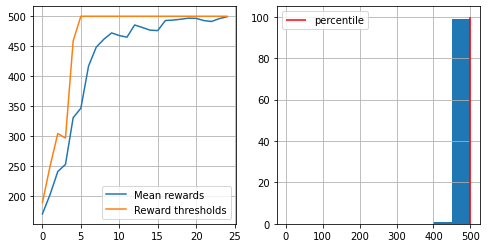

Mean Reward > 499. Learning Completed!
CPU times: user 2min 42s, sys: 813 ms, total: 2min 43s
Wall time: 2min 43s


In [22]:
%%time
n_sessions = 100
percentile = 70
log = []

for i in range(100):

    sessions = [generate_session(env, agent, timesteps_max=1000) for _ in range(n_sessions)]               # generate a list of n_sessions new sessions
    
    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)     # select elite actions

    agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 499:
        
        print("Mean Reward > 499. Learning Completed!")
        
        break

Remark:
- ***Mean reward reach 499 at around 25 sessions***. (Time spend: 2 min 43s)

In [9]:
# Record sessions

import gym.wrappers

with gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos_8.DeepCrossentropyMethod", force=True) as env_monitor:
    sessions = [generate_session(env_monitor, agent) for _ in range(100)]

2022-03-25 12:06:13.938 python[19174:778959] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fb611c38fe0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-03-25 12:06:13.939 python[19174:778959] Warning: Expected min height of view: (<NSButton: 0x7fb611830010>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-03-25 12:06:13.941 python[19174:778959] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fb611f1d1f0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-03-25 12:06:13.943 python[19174:778959] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fb611d9d130>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


In [13]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('videos_8.DeepCrossentropyMethod').iterdir() if s.suffix == '.mp4'])

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[-1]))  # You can also try other indices

# 9. Actor Critic NetWork

In [1]:
import gym
import numpy as np
from gym import wrappers

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp

import os
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense

import time

In [2]:
class ActorCriticNetWork(keras.Model):
    
    def __init__(self, 
                 num_actions,                                      # input layer
                 fc1_dims = 1024,                                  # first fully conneted layer
                 fc2_dims = 512,                                   # second fully conneted layer
                 model_name = 'actor_critic',
                 checkpoint_dir = 'tmp/actor_critic'):             # make this dir before start the learning
                
        super(ActorCriticNetWork, self).__init__()
        
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.num_actions = num_actions
        self.model_name = model_name
        self.checkpoint_dir = checkpoint_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, model_name + '_actor_critic')    # save as file name 
        
        self.fc1 = Dense(self.fc1_dims, activation = 'relu')       # input: self.fc1_dims, output: activation function Relu
        self.fc2 = Dense(self.fc2_dims, activation = 'relu')       # output: self.fc1_dims, output: activation function Relu
        
        self.value_function = Dense(1, activation = None)
        
        self.pi = Dense(num_actions, activation = 'softmax')       # policy pi output: num_actions - probability distribution add up equal to 1 
        
    def call(self, state):                                         # define the call function
        
        value = self.fc1(state)
        value = self.fc2(value)
        
        value_function = self.value_function(value)
        pi = self.pi(value)
        
        return value_function, pi 

In [3]:
class Agent:
    
    def __init__(self, alpha = 0.0003, gamma = 0.99, num_actions = 2):
        
        self.gamma = gamma                                                       # discount factor gamma
        self.num_actions = num_actions
        self.action = None
        self.action_space = [i for i in range(self.num_actions)]                 # list of action from 0 to x-1
        
        self.actor_critic = ActorCriticNetWork(num_actions = num_actions)        # input num_actions into the ActorCriticNetWork
        
        self.actor_critic.compile(optimizer = Adam(learning_rate = alpha))
                
    def choose_action(self, observation):
        
        state = tf.convert_to_tensor([observation])                              # convert observation into tensor format of state
        
        _, probs = self.actor_critic(state)                                      # input state into actor_critic to output probs 

        action_probabilities = tfp.distributions.Categorical(probs=probs)
        
        action = action_probabilities.sample()
        
        log_prob = action_probabilities.log_prob(action)
        
        self.action = action

        return action.numpy()[0]                                                 # return numpy version of action

    
    
    def save_models(self):
        
        print('... saving models ...')
        
        self.actor_critic.save_weights(self.actor_critic.checkpoint_file)

        
        
    def load_models(self):
        
        print('... loading models ...')
        
        self.actor_critic.load_weights(self.actor_critic.checkpoint_file)
        
        
        
    def learn(self, state, reward,  new_state, done):
        
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        
        new_state = tf.convert_to_tensor([new_state], dtype=tf.float32)
        
        reward = tf.convert_to_tensor(reward, dtype=tf.float32)                           # not fed to NN
        
        
        with tf.GradientTape(persistent=True) as tape:
            
            state_value, probs = self.actor_critic(state)
            
            new_state_value, _ = self.actor_critic(new_state)
            
            state_value = tf.squeeze(state_value)
            
            new_state_value = tf.squeeze(new_state_value)


            action_probs = tfp.distributions.Categorical(probs=probs)
            log_prob = action_probs.log_prob(self.action)

            
            delta = reward + self.gamma * new_state_value * (1 - int(done)) - state_value
            
            actor_loss = -log_prob * delta
            
            critic_loss = delta**2
            
            total_loss = actor_loss + critic_loss

            
        gradient = tape.gradient(total_loss, self.actor_critic.trainable_variables)
        
        self.actor_critic.optimizer.apply_gradients(zip(
                                                        gradient, 
                                                        self.actor_critic.trainable_variables
                                                        ))

In [9]:
%%time 
if __name__ == '__main__':
    
    env = gym.make('CartPole-v1')
    
    agent = Agent(alpha=1e-5, num_actions=env.action_space.n)
    
    num_games = 10000
    
    # uncomment this line and do a mkdir tmp && mkdir video if we want to record video of the agent playing the game.
    #env = wrappers.Monitor(env, 'tmp/video', video_callable=lambda episode_id: True, force=True)
    filename = 'cartpole_1e-5_1024x512_1800games.png'

    figure_file = 'plots/' + filename

    
    best_score = env.reward_range[0]
    score_history = []
    load_checkpoint = False

    
    if load_checkpoint:
        
        agent.load_models()

        
    for i in range(num_games):
        
        observation = env.reset()
        
        done = False
        
        score = 0
        
        while not done:
            
            action = agent.choose_action(observation)
            
            new_observation, reward, done, info = env.step(action)
            
            score += reward
            
            if not load_checkpoint:
                
                agent.learn(observation, reward, new_observation, done)
                
            observation = new_observation
            
        score_history.append(score)
        
        avg_score = np.mean(score_history[-100:])

        
        if avg_score > best_score:
            
            best_score = avg_score
            
            if not load_checkpoint:
                
                agent.save_models()

        print('episode ', i, 'score %.1f' % score, 'avg_score %.1f' % avg_score)

        
    if not load_checkpoint:
        
        x = [i+1 for i in range(num_games)]

... saving models ...
episode  0 score 24.0 avg_score 24.0
episode  1 score 11.0 avg_score 17.5
episode  2 score 23.0 avg_score 19.3
episode  3 score 18.0 avg_score 19.0
episode  4 score 11.0 avg_score 17.4
episode  5 score 20.0 avg_score 17.8
episode  6 score 19.0 avg_score 18.0
episode  7 score 18.0 avg_score 18.0
episode  8 score 10.0 avg_score 17.1
episode  9 score 25.0 avg_score 17.9
episode  10 score 26.0 avg_score 18.6
episode  11 score 33.0 avg_score 19.8
episode  12 score 20.0 avg_score 19.8
episode  13 score 11.0 avg_score 19.2
episode  14 score 20.0 avg_score 19.3
episode  15 score 28.0 avg_score 19.8
episode  16 score 13.0 avg_score 19.4
episode  17 score 16.0 avg_score 19.2
episode  18 score 12.0 avg_score 18.8
episode  19 score 24.0 avg_score 19.1
episode  20 score 12.0 avg_score 18.8
episode  21 score 24.0 avg_score 19.0
episode  22 score 60.0 avg_score 20.8
episode  23 score 23.0 avg_score 20.9
episode  24 score 28.0 avg_score 21.2
episode  25 score 26.0 avg_score 21.3


episode  213 score 39.0 avg_score 19.9
episode  214 score 38.0 avg_score 20.1
episode  215 score 14.0 avg_score 20.1
episode  216 score 10.0 avg_score 19.9
episode  217 score 21.0 avg_score 20.0
episode  218 score 16.0 avg_score 20.0
episode  219 score 40.0 avg_score 20.1
episode  220 score 12.0 avg_score 20.0
episode  221 score 23.0 avg_score 20.1
episode  222 score 27.0 avg_score 20.1
episode  223 score 39.0 avg_score 20.3
episode  224 score 16.0 avg_score 20.4
episode  225 score 18.0 avg_score 20.4
episode  226 score 45.0 avg_score 20.7
episode  227 score 30.0 avg_score 20.6
episode  228 score 9.0 avg_score 20.6
episode  229 score 28.0 avg_score 20.8
episode  230 score 24.0 avg_score 20.7
episode  231 score 19.0 avg_score 20.8
episode  232 score 10.0 avg_score 20.7
episode  233 score 18.0 avg_score 20.8
episode  234 score 14.0 avg_score 20.8
episode  235 score 33.0 avg_score 20.9
episode  236 score 56.0 avg_score 21.3
episode  237 score 24.0 avg_score 21.4
episode  238 score 27.0 av

episode  424 score 14.0 avg_score 18.1
episode  425 score 17.0 avg_score 18.1
episode  426 score 28.0 avg_score 18.2
episode  427 score 24.0 avg_score 18.3
episode  428 score 12.0 avg_score 18.3
episode  429 score 14.0 avg_score 18.2
episode  430 score 17.0 avg_score 18.2
episode  431 score 14.0 avg_score 18.2
episode  432 score 25.0 avg_score 18.4
episode  433 score 23.0 avg_score 18.4
episode  434 score 40.0 avg_score 18.5
episode  435 score 17.0 avg_score 18.5
episode  436 score 18.0 avg_score 18.4
episode  437 score 17.0 avg_score 18.2
episode  438 score 17.0 avg_score 18.2
episode  439 score 19.0 avg_score 18.1
episode  440 score 29.0 avg_score 18.3
episode  441 score 16.0 avg_score 18.3
episode  442 score 44.0 avg_score 18.6
episode  443 score 20.0 avg_score 18.6
episode  444 score 15.0 avg_score 18.6
episode  445 score 32.0 avg_score 18.8
episode  446 score 10.0 avg_score 18.7
episode  447 score 15.0 avg_score 18.6
episode  448 score 19.0 avg_score 18.7
episode  449 score 13.0 a

episode  635 score 39.0 avg_score 22.9
episode  636 score 15.0 avg_score 22.9
episode  637 score 19.0 avg_score 22.8
episode  638 score 30.0 avg_score 23.0
episode  639 score 33.0 avg_score 23.2
episode  640 score 9.0 avg_score 23.0
episode  641 score 22.0 avg_score 23.1
episode  642 score 18.0 avg_score 23.1
episode  643 score 25.0 avg_score 23.1
episode  644 score 29.0 avg_score 23.3
episode  645 score 13.0 avg_score 23.3
episode  646 score 11.0 avg_score 23.2
episode  647 score 22.0 avg_score 23.2
episode  648 score 18.0 avg_score 23.2
episode  649 score 8.0 avg_score 23.1
episode  650 score 38.0 avg_score 23.3
episode  651 score 25.0 avg_score 23.4
episode  652 score 11.0 avg_score 23.3
episode  653 score 26.0 avg_score 23.3
episode  654 score 37.0 avg_score 23.5
episode  655 score 38.0 avg_score 23.5
episode  656 score 32.0 avg_score 23.7
... saving models ...
episode  657 score 105.0 avg_score 24.6
... saving models ...
episode  658 score 37.0 avg_score 24.8
... saving models ...

episode  807 score 18.0 avg_score 39.0
episode  808 score 18.0 avg_score 37.9
episode  809 score 54.0 avg_score 37.8
episode  810 score 66.0 avg_score 38.3
episode  811 score 43.0 avg_score 38.5
episode  812 score 13.0 avg_score 38.5
episode  813 score 52.0 avg_score 38.4
episode  814 score 44.0 avg_score 38.4
episode  815 score 60.0 avg_score 38.9
episode  816 score 21.0 avg_score 38.7
episode  817 score 45.0 avg_score 39.0
... saving models ...
episode  818 score 106.0 avg_score 39.6
... saving models ...
episode  819 score 54.0 avg_score 39.8
... saving models ...
episode  820 score 24.0 avg_score 39.8
... saving models ...
episode  821 score 32.0 avg_score 40.0
... saving models ...
episode  822 score 28.0 avg_score 40.1
episode  823 score 16.0 avg_score 40.0
... saving models ...
episode  824 score 64.0 avg_score 40.2
... saving models ...
episode  825 score 27.0 avg_score 40.4
episode  826 score 39.0 avg_score 39.4
episode  827 score 23.0 avg_score 39.3
episode  828 score 43.0 av

... saving models ...
episode  970 score 71.0 avg_score 69.1
... saving models ...
episode  971 score 102.0 avg_score 69.7
... saving models ...
episode  972 score 98.0 avg_score 69.8
... saving models ...
episode  973 score 105.0 avg_score 70.5
... saving models ...
episode  974 score 99.0 avg_score 71.2
... saving models ...
episode  975 score 93.0 avg_score 71.7
episode  976 score 30.0 avg_score 71.3
episode  977 score 47.0 avg_score 70.5
episode  978 score 62.0 avg_score 70.5
episode  979 score 85.0 avg_score 70.5
episode  980 score 79.0 avg_score 70.9
... saving models ...
episode  981 score 178.0 avg_score 72.2
... saving models ...
episode  982 score 87.0 avg_score 72.5
... saving models ...
episode  983 score 51.0 avg_score 72.6
... saving models ...
episode  984 score 61.0 avg_score 72.8
... saving models ...
episode  985 score 89.0 avg_score 72.8
... saving models ...
episode  986 score 245.0 avg_score 74.9
episode  987 score 53.0 avg_score 74.2
episode  988 score 107.0 avg_s

... saving models ...
episode  1112 score 97.0 avg_score 140.4
... saving models ...
episode  1113 score 102.0 avg_score 140.7
... saving models ...
episode  1114 score 196.0 avg_score 141.4
... saving models ...
episode  1115 score 93.0 avg_score 141.8
episode  1116 score 110.0 avg_score 141.7
... saving models ...
episode  1117 score 158.0 avg_score 142.1
... saving models ...
episode  1118 score 166.0 avg_score 142.9
... saving models ...
episode  1119 score 150.0 avg_score 143.5
... saving models ...
episode  1120 score 116.0 avg_score 143.6
episode  1121 score 136.0 avg_score 143.4
episode  1122 score 93.0 avg_score 143.3
... saving models ...
episode  1123 score 238.0 avg_score 144.6
... saving models ...
episode  1124 score 161.0 avg_score 145.6
episode  1125 score 137.0 avg_score 144.9
episode  1126 score 132.0 avg_score 145.3
... saving models ...
episode  1127 score 134.0 avg_score 146.2
... saving models ...
episode  1128 score 222.0 avg_score 147.9
... saving models ...
epi

episode  1274 score 179.0 avg_score 179.8
episode  1275 score 215.0 avg_score 181.1
episode  1276 score 199.0 avg_score 181.1
episode  1277 score 156.0 avg_score 180.9
episode  1278 score 224.0 avg_score 181.8
episode  1279 score 239.0 avg_score 182.4
... saving models ...
episode  1280 score 329.0 avg_score 184.6
episode  1281 score 134.0 avg_score 183.7
episode  1282 score 116.0 avg_score 183.2
episode  1283 score 207.0 avg_score 183.9
... saving models ...
episode  1284 score 261.0 avg_score 185.0
... saving models ...
episode  1285 score 213.0 avg_score 185.6
... saving models ...
episode  1286 score 185.0 avg_score 186.0
... saving models ...
episode  1287 score 236.0 avg_score 186.1
... saving models ...
episode  1288 score 227.0 avg_score 186.2
... saving models ...
episode  1289 score 192.0 avg_score 186.7
... saving models ...
episode  1290 score 185.0 avg_score 187.2
episode  1291 score 143.0 avg_score 186.9
... saving models ...
episode  1292 score 313.0 avg_score 188.1
... 

episode  1450 score 298.0 avg_score 202.3
episode  1451 score 189.0 avg_score 202.2
episode  1452 score 201.0 avg_score 201.1
episode  1453 score 151.0 avg_score 200.2
episode  1454 score 345.0 avg_score 200.2
episode  1455 score 306.0 avg_score 201.3
episode  1456 score 239.0 avg_score 200.6
episode  1457 score 136.0 avg_score 200.0
episode  1458 score 246.0 avg_score 199.3
episode  1459 score 161.0 avg_score 199.3
episode  1460 score 411.0 avg_score 199.7
episode  1461 score 264.0 avg_score 199.9
episode  1462 score 263.0 avg_score 199.9
episode  1463 score 206.0 avg_score 199.3
episode  1464 score 149.0 avg_score 199.3
episode  1465 score 236.0 avg_score 199.9
episode  1466 score 180.0 avg_score 199.8
episode  1467 score 300.0 avg_score 201.5
episode  1468 score 205.0 avg_score 201.7
episode  1469 score 232.0 avg_score 201.2
episode  1470 score 209.0 avg_score 201.3
episode  1471 score 188.0 avg_score 201.1
episode  1472 score 338.0 avg_score 202.8
episode  1473 score 249.0 avg_scor

episode  1642 score 227.0 avg_score 199.3
episode  1643 score 197.0 avg_score 199.7
episode  1644 score 258.0 avg_score 198.4
episode  1645 score 207.0 avg_score 199.1
episode  1646 score 139.0 avg_score 198.8
episode  1647 score 232.0 avg_score 199.7
episode  1648 score 346.0 avg_score 201.8
episode  1649 score 201.0 avg_score 202.4
episode  1650 score 163.0 avg_score 202.7
episode  1651 score 180.0 avg_score 202.0
episode  1652 score 292.0 avg_score 203.2
episode  1653 score 156.0 avg_score 203.1
episode  1654 score 118.0 avg_score 202.8
episode  1655 score 168.0 avg_score 203.3
episode  1656 score 147.0 avg_score 203.0
episode  1657 score 132.0 avg_score 202.9
episode  1658 score 204.0 avg_score 203.4
episode  1659 score 133.0 avg_score 202.6
episode  1660 score 203.0 avg_score 203.3
episode  1661 score 161.0 avg_score 203.4
episode  1662 score 212.0 avg_score 203.5
episode  1663 score 121.0 avg_score 202.7
episode  1664 score 327.0 avg_score 204.4
episode  1665 score 196.0 avg_scor

episode  1835 score 170.0 avg_score 195.1
episode  1836 score 181.0 avg_score 195.0
episode  1837 score 153.0 avg_score 195.2
episode  1838 score 127.0 avg_score 194.6
episode  1839 score 137.0 avg_score 194.3
episode  1840 score 136.0 avg_score 193.5
episode  1841 score 127.0 avg_score 193.3
episode  1842 score 120.0 avg_score 189.6
episode  1843 score 148.0 avg_score 189.4
episode  1844 score 131.0 avg_score 189.1
episode  1845 score 143.0 avg_score 187.9
episode  1846 score 147.0 avg_score 184.9
episode  1847 score 163.0 avg_score 184.6
episode  1848 score 140.0 avg_score 183.9
episode  1849 score 121.0 avg_score 183.8
episode  1850 score 162.0 avg_score 180.4
episode  1851 score 223.0 avg_score 181.1
episode  1852 score 177.0 avg_score 181.6
episode  1853 score 174.0 avg_score 181.5
episode  1854 score 173.0 avg_score 181.4
episode  1855 score 142.0 avg_score 181.1
episode  1856 score 134.0 avg_score 180.7
episode  1857 score 148.0 avg_score 180.6
episode  1858 score 201.0 avg_scor

episode  2031 score 156.0 avg_score 197.8
episode  2032 score 200.0 avg_score 197.7
episode  2033 score 136.0 avg_score 197.4
episode  2034 score 157.0 avg_score 197.3
episode  2035 score 210.0 avg_score 197.5
episode  2036 score 344.0 avg_score 199.6
episode  2037 score 158.0 avg_score 200.2
episode  2038 score 395.0 avg_score 202.9
episode  2039 score 138.0 avg_score 202.3
episode  2040 score 235.0 avg_score 203.1
episode  2041 score 141.0 avg_score 201.2
episode  2042 score 142.0 avg_score 201.3
episode  2043 score 168.0 avg_score 201.7
episode  2044 score 361.0 avg_score 204.0
episode  2045 score 178.0 avg_score 203.9
episode  2046 score 285.0 avg_score 204.7
episode  2047 score 211.0 avg_score 205.7
episode  2048 score 365.0 avg_score 207.2
episode  2049 score 160.0 avg_score 207.3
episode  2050 score 168.0 avg_score 207.4
episode  2051 score 182.0 avg_score 208.1
episode  2052 score 221.0 avg_score 209.2
episode  2053 score 130.0 avg_score 208.5
episode  2054 score 268.0 avg_scor

episode  2227 score 170.0 avg_score 191.4
episode  2228 score 244.0 avg_score 190.5
episode  2229 score 232.0 avg_score 190.7
episode  2230 score 142.0 avg_score 189.1
episode  2231 score 207.0 avg_score 187.9
episode  2232 score 157.0 avg_score 187.8
episode  2233 score 179.0 avg_score 187.7
episode  2234 score 167.0 avg_score 188.1
episode  2235 score 263.0 avg_score 187.3
episode  2236 score 124.0 avg_score 187.1
episode  2237 score 162.0 avg_score 185.2
episode  2238 score 255.0 avg_score 186.1
episode  2239 score 226.0 avg_score 184.9
episode  2240 score 247.0 avg_score 185.8
episode  2241 score 147.0 avg_score 185.8
episode  2242 score 153.0 avg_score 185.0
episode  2243 score 293.0 avg_score 186.4
episode  2244 score 375.0 avg_score 188.3
episode  2245 score 173.0 avg_score 188.6
episode  2246 score 128.0 avg_score 188.2
episode  2247 score 335.0 avg_score 190.1
episode  2248 score 217.0 avg_score 190.4
episode  2249 score 212.0 avg_score 191.1
episode  2250 score 222.0 avg_scor

episode  2423 score 144.0 avg_score 202.6
episode  2424 score 127.0 avg_score 202.7
episode  2425 score 407.0 avg_score 205.1
episode  2426 score 159.0 avg_score 205.2
episode  2427 score 138.0 avg_score 203.2
episode  2428 score 155.0 avg_score 203.2
episode  2429 score 346.0 avg_score 204.4
episode  2430 score 190.0 avg_score 202.2
episode  2431 score 128.0 avg_score 201.7
episode  2432 score 269.0 avg_score 202.9
episode  2433 score 172.0 avg_score 203.0
episode  2434 score 212.0 avg_score 203.7
episode  2435 score 108.0 avg_score 203.5
episode  2436 score 151.0 avg_score 203.2
episode  2437 score 299.0 avg_score 204.7
episode  2438 score 393.0 avg_score 205.9
episode  2439 score 203.0 avg_score 206.7
episode  2440 score 184.0 avg_score 205.9
episode  2441 score 163.0 avg_score 203.9
episode  2442 score 233.0 avg_score 203.5
episode  2443 score 139.0 avg_score 201.1
episode  2444 score 313.0 avg_score 202.5
episode  2445 score 150.0 avg_score 202.7
episode  2446 score 143.0 avg_scor

episode  2619 score 186.0 avg_score 207.4
episode  2620 score 335.0 avg_score 208.5
episode  2621 score 169.0 avg_score 207.2
episode  2622 score 149.0 avg_score 206.5
episode  2623 score 157.0 avg_score 205.7
episode  2624 score 166.0 avg_score 205.5
episode  2625 score 273.0 avg_score 206.2
episode  2626 score 191.0 avg_score 206.4
episode  2627 score 151.0 avg_score 206.7
episode  2628 score 166.0 avg_score 206.6
episode  2629 score 261.0 avg_score 207.5
episode  2630 score 199.0 avg_score 207.5
episode  2631 score 138.0 avg_score 205.9
episode  2632 score 123.0 avg_score 204.5
episode  2633 score 133.0 avg_score 204.7
episode  2634 score 136.0 avg_score 204.4
episode  2635 score 185.0 avg_score 203.7
episode  2636 score 179.0 avg_score 203.2
episode  2637 score 180.0 avg_score 203.4
episode  2638 score 133.0 avg_score 202.1
episode  2639 score 150.0 avg_score 202.1
episode  2640 score 260.0 avg_score 202.7
episode  2641 score 178.0 avg_score 203.1
episode  2642 score 140.0 avg_scor

episode  2814 score 113.0 avg_score 197.2
episode  2815 score 414.0 avg_score 198.1
episode  2816 score 171.0 avg_score 194.8
episode  2817 score 139.0 avg_score 194.4
episode  2818 score 152.0 avg_score 193.3
episode  2819 score 304.0 avg_score 194.5
episode  2820 score 138.0 avg_score 194.0
episode  2821 score 336.0 avg_score 195.9
episode  2822 score 353.0 avg_score 197.9
episode  2823 score 180.0 avg_score 195.4
episode  2824 score 186.0 avg_score 194.5
episode  2825 score 200.0 avg_score 194.6
episode  2826 score 321.0 avg_score 196.0
episode  2827 score 137.0 avg_score 196.1
episode  2828 score 162.0 avg_score 196.0
episode  2829 score 268.0 avg_score 196.2
episode  2830 score 163.0 avg_score 196.4
episode  2831 score 255.0 avg_score 197.5
episode  2832 score 201.0 avg_score 198.0
episode  2833 score 138.0 avg_score 197.5
episode  2834 score 113.0 avg_score 196.8
episode  2835 score 228.0 avg_score 196.1
episode  2836 score 128.0 avg_score 194.9
episode  2837 score 210.0 avg_scor

episode  3010 score 124.0 avg_score 199.2
episode  3011 score 158.0 avg_score 196.6
episode  3012 score 199.0 avg_score 197.3
episode  3013 score 108.0 avg_score 197.2
episode  3014 score 334.0 avg_score 198.4
episode  3015 score 123.0 avg_score 197.1
episode  3016 score 243.0 avg_score 197.9
episode  3017 score 219.0 avg_score 198.6
episode  3018 score 141.0 avg_score 197.9
episode  3019 score 130.0 avg_score 196.5
episode  3020 score 219.0 avg_score 197.5
episode  3021 score 243.0 avg_score 198.4
episode  3022 score 133.0 avg_score 198.2
episode  3023 score 275.0 avg_score 199.4
episode  3024 score 136.0 avg_score 199.6
episode  3025 score 174.0 avg_score 198.1
episode  3026 score 186.0 avg_score 197.2
episode  3027 score 206.0 avg_score 198.0
episode  3028 score 133.0 avg_score 197.2
episode  3029 score 283.0 avg_score 198.5
episode  3030 score 293.0 avg_score 200.1
episode  3031 score 149.0 avg_score 199.3
episode  3032 score 139.0 avg_score 199.3
episode  3033 score 137.0 avg_scor

episode  3197 score 116.0 avg_score 211.3
episode  3198 score 243.0 avg_score 211.6
episode  3199 score 111.0 avg_score 211.2
episode  3200 score 147.0 avg_score 210.5
episode  3201 score 490.0 avg_score 212.7
episode  3202 score 150.0 avg_score 212.5
episode  3203 score 145.0 avg_score 211.7
episode  3204 score 270.0 avg_score 212.6
episode  3205 score 241.0 avg_score 213.4
episode  3206 score 251.0 avg_score 214.6
episode  3207 score 204.0 avg_score 215.5
episode  3208 score 177.0 avg_score 216.0
episode  3209 score 212.0 avg_score 215.7
episode  3210 score 125.0 avg_score 211.9
episode  3211 score 244.0 avg_score 210.7
episode  3212 score 150.0 avg_score 208.9
episode  3213 score 181.0 avg_score 208.0
episode  3214 score 184.0 avg_score 204.9
episode  3215 score 500.0 avg_score 208.4
episode  3216 score 338.0 avg_score 207.9
episode  3217 score 137.0 avg_score 205.9
episode  3218 score 261.0 avg_score 207.2
episode  3219 score 169.0 avg_score 206.8
episode  3220 score 226.0 avg_scor

episode  3393 score 126.0 avg_score 222.7
episode  3394 score 159.0 avg_score 221.3
episode  3395 score 111.0 avg_score 220.2
episode  3396 score 265.0 avg_score 218.8
episode  3397 score 272.0 avg_score 220.2
episode  3398 score 153.0 avg_score 219.7
episode  3399 score 203.0 avg_score 219.2
episode  3400 score 106.0 avg_score 218.9
episode  3401 score 275.0 avg_score 220.2
episode  3402 score 244.0 avg_score 219.1
episode  3403 score 115.0 avg_score 218.4
episode  3404 score 135.0 avg_score 217.7
episode  3405 score 169.0 avg_score 215.9
episode  3406 score 296.0 avg_score 214.9
episode  3407 score 250.0 avg_score 215.3
episode  3408 score 258.0 avg_score 213.8
episode  3409 score 114.0 avg_score 213.0
episode  3410 score 132.0 avg_score 212.6
episode  3411 score 248.0 avg_score 213.6
episode  3412 score 249.0 avg_score 213.1
episode  3413 score 153.0 avg_score 212.1
episode  3414 score 275.0 avg_score 211.4
episode  3415 score 145.0 avg_score 210.8
episode  3416 score 143.0 avg_scor

episode  3589 score 141.0 avg_score 199.9
episode  3590 score 118.0 avg_score 199.5
episode  3591 score 239.0 avg_score 200.1
episode  3592 score 138.0 avg_score 197.5
episode  3593 score 177.0 avg_score 197.9
episode  3594 score 333.0 avg_score 199.5
episode  3595 score 158.0 avg_score 199.8
episode  3596 score 137.0 avg_score 197.3
episode  3597 score 149.0 avg_score 197.2
episode  3598 score 155.0 avg_score 197.1
episode  3599 score 139.0 avg_score 197.4
episode  3600 score 169.0 avg_score 196.7
episode  3601 score 146.0 avg_score 196.7
episode  3602 score 149.0 avg_score 196.8
episode  3603 score 169.0 avg_score 197.3
episode  3604 score 277.0 avg_score 198.5
episode  3605 score 158.0 avg_score 198.6
episode  3606 score 355.0 avg_score 198.7
episode  3607 score 253.0 avg_score 200.2
episode  3608 score 326.0 avg_score 200.9
episode  3609 score 128.0 avg_score 200.9
episode  3610 score 232.0 avg_score 201.7
episode  3611 score 209.0 avg_score 202.5
episode  3612 score 372.0 avg_scor

episode  3785 score 141.0 avg_score 202.6
episode  3786 score 121.0 avg_score 201.0
episode  3787 score 118.0 avg_score 198.3
episode  3788 score 120.0 avg_score 196.7
episode  3789 score 309.0 avg_score 197.6
episode  3790 score 130.0 avg_score 197.6
episode  3791 score 153.0 avg_score 197.5
episode  3792 score 163.0 avg_score 197.3
episode  3793 score 118.0 avg_score 197.1
episode  3794 score 186.0 avg_score 196.1
episode  3795 score 400.0 avg_score 198.5
episode  3796 score 165.0 avg_score 199.1
episode  3797 score 315.0 avg_score 200.2
episode  3798 score 119.0 avg_score 199.2
episode  3799 score 161.0 avg_score 197.6
episode  3800 score 187.0 avg_score 198.1
episode  3801 score 118.0 avg_score 197.4
episode  3802 score 176.0 avg_score 197.6
episode  3803 score 216.0 avg_score 197.7
episode  3804 score 207.0 avg_score 198.4
episode  3805 score 213.0 avg_score 199.3
episode  3806 score 323.0 avg_score 201.2
episode  3807 score 358.0 avg_score 201.3
episode  3808 score 126.0 avg_scor

episode  3974 score 316.0 avg_score 242.5
episode  3975 score 256.0 avg_score 243.8
episode  3976 score 223.0 avg_score 244.6
episode  3977 score 206.0 avg_score 243.1
episode  3978 score 170.0 avg_score 243.7
episode  3979 score 203.0 avg_score 242.8
episode  3980 score 448.0 avg_score 245.8
episode  3981 score 278.0 avg_score 245.6
episode  3982 score 225.0 avg_score 246.5
... saving models ...
episode  3983 score 363.0 avg_score 248.7
... saving models ...
episode  3984 score 286.0 avg_score 250.2
... saving models ...
episode  3985 score 130.0 avg_score 250.2
episode  3986 score 116.0 avg_score 247.8
episode  3987 score 195.0 avg_score 248.3
episode  3988 score 126.0 avg_score 247.7
episode  3989 score 351.0 avg_score 247.9
episode  3990 score 169.0 avg_score 244.6
episode  3991 score 141.0 avg_score 244.4
episode  3992 score 201.0 avg_score 244.5
episode  3993 score 140.0 avg_score 243.4
episode  3994 score 303.0 avg_score 243.4
episode  3995 score 314.0 avg_score 245.1
episode  3

episode  4168 score 197.0 avg_score 228.8
episode  4169 score 144.0 avg_score 228.5
episode  4170 score 181.0 avg_score 228.6
episode  4171 score 147.0 avg_score 228.0
episode  4172 score 153.0 avg_score 225.8
episode  4173 score 289.0 avg_score 227.2
episode  4174 score 294.0 avg_score 228.3
episode  4175 score 157.0 avg_score 225.8
episode  4176 score 156.0 avg_score 224.9
episode  4177 score 168.0 avg_score 224.7
episode  4178 score 314.0 avg_score 226.0
episode  4179 score 169.0 avg_score 223.9
episode  4180 score 162.0 avg_score 224.0
episode  4181 score 118.0 avg_score 223.4
episode  4182 score 188.0 avg_score 223.4
episode  4183 score 328.0 avg_score 223.1
episode  4184 score 135.0 avg_score 223.1
episode  4185 score 223.0 avg_score 224.0
episode  4186 score 324.0 avg_score 223.5
episode  4187 score 195.0 avg_score 222.5
episode  4188 score 159.0 avg_score 222.2
episode  4189 score 470.0 avg_score 224.8
episode  4190 score 142.0 avg_score 224.1
episode  4191 score 211.0 avg_scor

episode  4364 score 189.0 avg_score 240.2
episode  4365 score 500.0 avg_score 242.9
episode  4366 score 145.0 avg_score 242.4
episode  4367 score 224.0 avg_score 243.2
episode  4368 score 148.0 avg_score 243.2
episode  4369 score 151.0 avg_score 242.9
episode  4370 score 149.0 avg_score 240.8
episode  4371 score 249.0 avg_score 241.5
episode  4372 score 383.0 avg_score 243.9
episode  4373 score 325.0 avg_score 244.4
episode  4374 score 145.0 avg_score 244.0
episode  4375 score 221.0 avg_score 244.4
episode  4376 score 154.0 avg_score 244.2
episode  4377 score 242.0 avg_score 243.8
episode  4378 score 197.0 avg_score 244.5
episode  4379 score 203.0 avg_score 245.2
episode  4380 score 141.0 avg_score 244.1
episode  4381 score 159.0 avg_score 243.8
episode  4382 score 173.0 avg_score 242.8
episode  4383 score 253.0 avg_score 241.7
episode  4384 score 178.0 avg_score 241.8
episode  4385 score 328.0 avg_score 243.7
episode  4386 score 339.0 avg_score 244.8
episode  4387 score 314.0 avg_scor

episode  4557 score 315.0 avg_score 254.2
episode  4558 score 184.0 avg_score 253.3
episode  4559 score 223.0 avg_score 254.2
episode  4560 score 175.0 avg_score 254.4
episode  4561 score 165.0 avg_score 254.6
episode  4562 score 198.0 avg_score 254.8
episode  4563 score 159.0 avg_score 255.0
episode  4564 score 146.0 avg_score 254.9
episode  4565 score 226.0 avg_score 254.1
episode  4566 score 181.0 avg_score 254.2
episode  4567 score 143.0 avg_score 254.2
... saving models ...
episode  4568 score 422.0 avg_score 255.3
... saving models ...
episode  4569 score 404.0 avg_score 256.3
episode  4570 score 162.0 avg_score 252.9
episode  4571 score 290.0 avg_score 252.1
episode  4572 score 146.0 avg_score 251.2
episode  4573 score 349.0 avg_score 253.0
episode  4574 score 196.0 avg_score 253.0
episode  4575 score 340.0 avg_score 252.4
episode  4576 score 350.0 avg_score 253.7
episode  4577 score 339.0 avg_score 255.7
episode  4578 score 250.0 avg_score 254.9
episode  4579 score 154.0 avg_sc

episode  4743 score 407.0 avg_score 260.1
episode  4744 score 300.0 avg_score 261.4
episode  4745 score 500.0 avg_score 261.4
episode  4746 score 154.0 avg_score 260.4
episode  4747 score 160.0 avg_score 258.6
episode  4748 score 157.0 avg_score 255.1
episode  4749 score 297.0 avg_score 256.1
episode  4750 score 178.0 avg_score 256.3
episode  4751 score 307.0 avg_score 256.6
episode  4752 score 165.0 avg_score 256.6
episode  4753 score 258.0 avg_score 256.1
episode  4754 score 500.0 avg_score 257.6
episode  4755 score 397.0 avg_score 258.6
episode  4756 score 184.0 avg_score 259.1
episode  4757 score 348.0 avg_score 261.0
episode  4758 score 272.0 avg_score 260.4
episode  4759 score 169.0 avg_score 257.1
episode  4760 score 286.0 avg_score 257.2
episode  4761 score 160.0 avg_score 257.0
episode  4762 score 318.0 avg_score 256.7
episode  4763 score 159.0 avg_score 253.6
episode  4764 score 324.0 avg_score 252.9
episode  4765 score 163.0 avg_score 252.6
episode  4766 score 321.0 avg_scor

episode  4939 score 472.0 avg_score 263.1
episode  4940 score 167.0 avg_score 262.6
episode  4941 score 184.0 avg_score 261.1
episode  4942 score 365.0 avg_score 262.8
episode  4943 score 130.0 avg_score 262.0
episode  4944 score 182.0 avg_score 261.4
episode  4945 score 500.0 avg_score 261.5
episode  4946 score 487.0 avg_score 264.1
episode  4947 score 141.0 avg_score 263.6
episode  4948 score 138.0 avg_score 262.5
episode  4949 score 188.0 avg_score 261.0
episode  4950 score 135.0 avg_score 260.1
episode  4951 score 242.0 avg_score 260.7
episode  4952 score 188.0 avg_score 260.9
episode  4953 score 168.0 avg_score 260.7
episode  4954 score 190.0 avg_score 260.6
episode  4955 score 177.0 avg_score 258.9
episode  4956 score 175.0 avg_score 257.2
episode  4957 score 377.0 avg_score 258.7
episode  4958 score 209.0 avg_score 258.8
episode  4959 score 323.0 avg_score 260.0
episode  4960 score 473.0 avg_score 262.5
episode  4961 score 164.0 avg_score 261.5
episode  4962 score 177.0 avg_scor

episode  5127 score 137.0 avg_score 261.0
episode  5128 score 174.0 avg_score 257.7
episode  5129 score 202.0 avg_score 258.1
episode  5130 score 148.0 avg_score 258.0
episode  5131 score 369.0 avg_score 259.6
episode  5132 score 286.0 avg_score 258.8
episode  5133 score 180.0 avg_score 259.1
episode  5134 score 237.0 avg_score 256.5
episode  5135 score 275.0 avg_score 257.2
episode  5136 score 210.0 avg_score 257.9
episode  5137 score 145.0 avg_score 254.8
episode  5138 score 273.0 avg_score 255.0
episode  5139 score 212.0 avg_score 255.5
episode  5140 score 173.0 avg_score 254.6
episode  5141 score 331.0 avg_score 256.1
episode  5142 score 172.0 avg_score 255.6
episode  5143 score 239.0 avg_score 253.0
episode  5144 score 140.0 avg_score 252.0
episode  5145 score 164.0 avg_score 252.3
episode  5146 score 385.0 avg_score 251.1
episode  5147 score 380.0 avg_score 253.2
episode  5148 score 144.0 avg_score 252.2
episode  5149 score 475.0 avg_score 255.3
episode  5150 score 380.0 avg_scor

episode  5323 score 149.0 avg_score 266.0
episode  5324 score 198.0 avg_score 265.4
episode  5325 score 282.0 avg_score 265.7
episode  5326 score 210.0 avg_score 266.1
episode  5327 score 229.0 avg_score 263.4
episode  5328 score 408.0 avg_score 263.8
episode  5329 score 435.0 avg_score 265.5
episode  5330 score 500.0 avg_score 268.9
episode  5331 score 229.0 avg_score 269.2
episode  5332 score 500.0 avg_score 270.5
episode  5333 score 237.0 avg_score 271.4
episode  5334 score 249.0 avg_score 272.3
episode  5335 score 277.0 avg_score 270.1
episode  5336 score 148.0 avg_score 267.6
episode  5337 score 365.0 avg_score 269.1
episode  5338 score 309.0 avg_score 270.8
episode  5339 score 188.0 avg_score 271.2
episode  5340 score 139.0 avg_score 271.1
episode  5341 score 321.0 avg_score 272.3
episode  5342 score 462.0 avg_score 274.1
episode  5343 score 181.0 avg_score 272.5
episode  5344 score 403.0 avg_score 271.7
episode  5345 score 412.0 avg_score 274.3
episode  5346 score 500.0 avg_scor

episode  5511 score 187.0 avg_score 286.8
episode  5512 score 500.0 avg_score 289.6
episode  5513 score 357.0 avg_score 290.1
episode  5514 score 258.0 avg_score 287.7
episode  5515 score 282.0 avg_score 285.7
episode  5516 score 328.0 avg_score 286.5
episode  5517 score 147.0 avg_score 283.4
episode  5518 score 149.0 avg_score 283.1
episode  5519 score 216.0 avg_score 283.7
episode  5520 score 268.0 avg_score 283.0
episode  5521 score 146.0 avg_score 279.7
episode  5522 score 160.0 avg_score 278.4
episode  5523 score 291.0 avg_score 279.5
episode  5524 score 166.0 avg_score 277.2
episode  5525 score 199.0 avg_score 277.6
episode  5526 score 500.0 avg_score 279.4
episode  5527 score 238.0 avg_score 280.3
episode  5528 score 500.0 avg_score 283.6
episode  5529 score 269.0 avg_score 282.3
episode  5530 score 384.0 avg_score 284.3
episode  5531 score 178.0 avg_score 281.1
episode  5532 score 137.0 avg_score 279.5
episode  5533 score 163.0 avg_score 276.1
episode  5534 score 144.0 avg_scor

episode  5707 score 162.0 avg_score 266.7
episode  5708 score 357.0 avg_score 267.9
episode  5709 score 382.0 avg_score 267.8
episode  5710 score 234.0 avg_score 266.2
episode  5711 score 330.0 avg_score 267.0
episode  5712 score 178.0 avg_score 267.3
episode  5713 score 155.0 avg_score 266.6
episode  5714 score 147.0 avg_score 266.5
episode  5715 score 398.0 avg_score 269.0
episode  5716 score 247.0 avg_score 269.9
episode  5717 score 166.0 avg_score 269.9
episode  5718 score 296.0 avg_score 270.6
episode  5719 score 226.0 avg_score 269.7
episode  5720 score 495.0 avg_score 271.4
episode  5721 score 285.0 avg_score 271.8
episode  5722 score 141.0 avg_score 271.1
episode  5723 score 147.0 avg_score 271.2
episode  5724 score 153.0 avg_score 270.5
episode  5725 score 154.0 avg_score 270.5
episode  5726 score 226.0 avg_score 268.1
episode  5727 score 148.0 avg_score 266.8
episode  5728 score 295.0 avg_score 268.0
episode  5729 score 284.0 avg_score 269.2
episode  5730 score 500.0 avg_scor

episode  5902 score 177.0 avg_score 256.7
episode  5903 score 298.0 avg_score 254.7
episode  5904 score 500.0 avg_score 256.6
episode  5905 score 148.0 avg_score 253.5
episode  5906 score 155.0 avg_score 253.5
episode  5907 score 302.0 avg_score 254.6
episode  5908 score 500.0 avg_score 257.9
episode  5909 score 500.0 avg_score 261.2
episode  5910 score 164.0 avg_score 261.3
episode  5911 score 148.0 avg_score 257.8
episode  5912 score 191.0 avg_score 256.8
episode  5913 score 144.0 avg_score 253.3
episode  5914 score 491.0 avg_score 255.3
episode  5915 score 348.0 avg_score 257.1
episode  5916 score 303.0 avg_score 256.5
episode  5917 score 186.0 avg_score 256.4
episode  5918 score 133.0 avg_score 254.4
episode  5919 score 161.0 avg_score 254.6
episode  5920 score 274.0 avg_score 255.6
episode  5921 score 254.0 avg_score 253.1
episode  5922 score 202.0 avg_score 253.4
episode  5923 score 500.0 avg_score 255.9
episode  5924 score 176.0 avg_score 254.9
episode  5925 score 379.0 avg_scor

episode  6098 score 254.0 avg_score 257.9
episode  6099 score 177.0 avg_score 258.1
episode  6100 score 428.0 avg_score 259.8
episode  6101 score 259.0 avg_score 260.0
episode  6102 score 500.0 avg_score 263.6
episode  6103 score 287.0 avg_score 264.7
episode  6104 score 328.0 avg_score 266.5
episode  6105 score 500.0 avg_score 267.8
episode  6106 score 242.0 avg_score 267.4
episode  6107 score 298.0 avg_score 267.5
episode  6108 score 495.0 avg_score 269.8
episode  6109 score 431.0 avg_score 271.1
episode  6110 score 147.0 avg_score 269.0
episode  6111 score 153.0 avg_score 269.1
episode  6112 score 141.0 avg_score 267.8
episode  6113 score 500.0 avg_score 271.1
episode  6114 score 156.0 avg_score 267.8
episode  6115 score 352.0 avg_score 268.7
episode  6116 score 131.0 avg_score 268.5
episode  6117 score 140.0 avg_score 267.9
episode  6118 score 150.0 avg_score 268.0
episode  6119 score 327.0 avg_score 267.3
episode  6120 score 402.0 avg_score 266.3
episode  6121 score 206.0 avg_scor

episode  6294 score 483.0 avg_score 265.4
episode  6295 score 153.0 avg_score 264.3
episode  6296 score 152.0 avg_score 264.4
episode  6297 score 500.0 avg_score 267.6
episode  6298 score 286.0 avg_score 265.4
episode  6299 score 161.0 avg_score 263.2
episode  6300 score 500.0 avg_score 264.3
episode  6301 score 177.0 avg_score 261.1
episode  6302 score 210.0 avg_score 261.8
episode  6303 score 379.0 avg_score 261.6
episode  6304 score 205.0 avg_score 262.2
episode  6305 score 156.0 avg_score 262.2
episode  6306 score 451.0 avg_score 264.5
episode  6307 score 500.0 avg_score 266.5
episode  6308 score 184.0 avg_score 266.8
episode  6309 score 343.0 avg_score 265.2
episode  6310 score 164.0 avg_score 261.9
episode  6311 score 140.0 avg_score 260.1
episode  6312 score 500.0 avg_score 263.2
episode  6313 score 314.0 avg_score 263.5
episode  6314 score 196.0 avg_score 263.4
episode  6315 score 175.0 avg_score 263.8
episode  6316 score 256.0 avg_score 264.9
episode  6317 score 175.0 avg_scor

episode  6487 score 196.0 avg_score 296.2
episode  6488 score 382.0 avg_score 298.4
episode  6489 score 500.0 avg_score 298.8
episode  6490 score 140.0 avg_score 298.8
episode  6491 score 337.0 avg_score 297.2
episode  6492 score 500.0 avg_score 300.2
episode  6493 score 155.0 avg_score 299.8
episode  6494 score 259.0 avg_score 298.1
episode  6495 score 162.0 avg_score 297.5
episode  6496 score 298.0 avg_score 295.5
episode  6497 score 460.0 avg_score 296.8
episode  6498 score 198.0 avg_score 297.1
episode  6499 score 373.0 avg_score 295.8
episode  6500 score 184.0 avg_score 294.5
episode  6501 score 270.0 avg_score 293.2
episode  6502 score 164.0 avg_score 293.1
episode  6503 score 345.0 avg_score 294.7
episode  6504 score 500.0 avg_score 297.9
episode  6505 score 259.0 avg_score 298.8
episode  6506 score 176.0 avg_score 296.5
episode  6507 score 464.0 avg_score 297.3
episode  6508 score 258.0 avg_score 298.2
episode  6509 score 172.0 avg_score 294.9
episode  6510 score 146.0 avg_scor

episode  6683 score 220.0 avg_score 277.4
episode  6684 score 135.0 avg_score 276.8
episode  6685 score 263.0 avg_score 277.9
episode  6686 score 153.0 avg_score 276.5
episode  6687 score 165.0 avg_score 275.0
episode  6688 score 500.0 avg_score 278.4
episode  6689 score 152.0 avg_score 278.2
episode  6690 score 249.0 avg_score 279.1
episode  6691 score 485.0 avg_score 281.4
episode  6692 score 240.0 avg_score 281.9
episode  6693 score 265.0 avg_score 279.5
episode  6694 score 168.0 avg_score 278.2
episode  6695 score 324.0 avg_score 278.9
episode  6696 score 227.0 avg_score 277.4
episode  6697 score 170.0 avg_score 276.4
episode  6698 score 161.0 avg_score 276.1
episode  6699 score 173.0 avg_score 276.1
episode  6700 score 204.0 avg_score 274.4
episode  6701 score 500.0 avg_score 277.2
episode  6702 score 177.0 avg_score 276.7
episode  6703 score 206.0 avg_score 275.8
episode  6704 score 231.0 avg_score 276.4
episode  6705 score 379.0 avg_score 278.5
episode  6706 score 500.0 avg_scor

episode  6876 score 329.0 avg_score 273.0
episode  6877 score 500.0 avg_score 273.0
episode  6878 score 416.0 avg_score 272.1
episode  6879 score 148.0 avg_score 271.7
episode  6880 score 179.0 avg_score 269.8
episode  6881 score 150.0 avg_score 266.3
episode  6882 score 269.0 avg_score 267.3
episode  6883 score 146.0 avg_score 266.2
episode  6884 score 173.0 avg_score 265.9
episode  6885 score 169.0 avg_score 265.0
episode  6886 score 427.0 avg_score 266.8
episode  6887 score 146.0 avg_score 266.9
episode  6888 score 392.0 avg_score 266.9
episode  6889 score 497.0 avg_score 267.4
episode  6890 score 500.0 avg_score 268.7
episode  6891 score 270.0 avg_score 267.2
episode  6892 score 155.0 avg_score 263.7
episode  6893 score 253.0 avg_score 264.6
episode  6894 score 161.0 avg_score 263.6
episode  6895 score 211.0 avg_score 263.4
episode  6896 score 199.0 avg_score 263.8
episode  6897 score 160.0 avg_score 261.2
episode  6898 score 193.0 avg_score 261.6
episode  6899 score 146.0 avg_scor

episode  7069 score 187.0 avg_score 310.1
episode  7070 score 419.0 avg_score 309.9
episode  7071 score 317.0 avg_score 309.0
episode  7072 score 495.0 avg_score 311.7
episode  7073 score 166.0 avg_score 311.9
episode  7074 score 314.0 avg_score 313.4
... saving models ...
episode  7075 score 389.0 avg_score 315.7
... saving models ...
episode  7076 score 236.0 avg_score 316.6
episode  7077 score 500.0 avg_score 316.6
episode  7078 score 462.0 avg_score 316.2
episode  7079 score 235.0 avg_score 313.6
episode  7080 score 335.0 avg_score 314.6
episode  7081 score 478.0 avg_score 316.1
episode  7082 score 185.0 avg_score 316.2
... saving models ...
episode  7083 score 252.0 avg_score 317.0
episode  7084 score 241.0 avg_score 314.4
episode  7085 score 500.0 avg_score 314.9
... saving models ...
episode  7086 score 494.0 avg_score 318.4
... saving models ...
episode  7087 score 247.0 avg_score 318.4
episode  7088 score 208.0 avg_score 315.5
episode  7089 score 500.0 avg_score 315.9
episode 

episode  7262 score 390.0 avg_score 280.2
episode  7263 score 454.0 avg_score 283.0
episode  7264 score 174.0 avg_score 281.3
episode  7265 score 262.0 avg_score 280.3
episode  7266 score 147.0 avg_score 280.2
episode  7267 score 220.0 avg_score 281.1
episode  7268 score 179.0 avg_score 281.2
episode  7269 score 181.0 avg_score 281.3
episode  7270 score 227.0 avg_score 278.6
episode  7271 score 352.0 avg_score 278.6
episode  7272 score 150.0 avg_score 277.4
episode  7273 score 238.0 avg_score 276.6
episode  7274 score 310.0 avg_score 275.4
episode  7275 score 302.0 avg_score 276.9
episode  7276 score 500.0 avg_score 280.2
episode  7277 score 383.0 avg_score 279.6
episode  7278 score 500.0 avg_score 279.6
episode  7279 score 191.0 avg_score 279.7
episode  7280 score 149.0 avg_score 279.7
episode  7281 score 500.0 avg_score 282.9
episode  7282 score 145.0 avg_score 282.9
episode  7283 score 160.0 avg_score 279.5
episode  7284 score 179.0 avg_score 277.4
episode  7285 score 196.0 avg_scor

episode  7458 score 500.0 avg_score 287.5
episode  7459 score 445.0 avg_score 290.2
episode  7460 score 153.0 avg_score 286.9
episode  7461 score 345.0 avg_score 285.3
episode  7462 score 377.0 avg_score 287.5
episode  7463 score 500.0 avg_score 288.5
episode  7464 score 283.0 avg_score 288.8
episode  7465 score 174.0 avg_score 286.8
episode  7466 score 152.0 avg_score 286.1
episode  7467 score 236.0 avg_score 284.2
episode  7468 score 182.0 avg_score 284.6
episode  7469 score 470.0 avg_score 287.6
episode  7470 score 310.0 avg_score 289.2
episode  7471 score 500.0 avg_score 292.6
episode  7472 score 262.0 avg_score 290.2
episode  7473 score 160.0 avg_score 289.3
episode  7474 score 217.0 avg_score 286.5
episode  7475 score 176.0 avg_score 286.8
episode  7476 score 188.0 avg_score 286.9
episode  7477 score 460.0 avg_score 289.0
episode  7478 score 500.0 avg_score 291.4
episode  7479 score 500.0 avg_score 294.5
episode  7480 score 147.0 avg_score 294.6
episode  7481 score 500.0 avg_scor

episode  7654 score 139.0 avg_score 284.9
episode  7655 score 212.0 avg_score 284.4
episode  7656 score 358.0 avg_score 286.5
episode  7657 score 247.0 avg_score 284.6
episode  7658 score 500.0 avg_score 286.9
episode  7659 score 162.0 avg_score 286.9
episode  7660 score 167.0 avg_score 286.7
episode  7661 score 397.0 avg_score 285.7
episode  7662 score 407.0 avg_score 286.0
episode  7663 score 329.0 avg_score 284.6
episode  7664 score 179.0 avg_score 283.8
episode  7665 score 163.0 avg_score 283.7
episode  7666 score 237.0 avg_score 284.5
episode  7667 score 434.0 avg_score 287.2
episode  7668 score 254.0 avg_score 286.4
episode  7669 score 480.0 avg_score 288.6
episode  7670 score 500.0 avg_score 290.9
episode  7671 score 149.0 avg_score 290.7
episode  7672 score 155.0 avg_score 290.6
episode  7673 score 370.0 avg_score 292.7
episode  7674 score 470.0 avg_score 294.3
episode  7675 score 162.0 avg_score 294.0
episode  7676 score 164.0 avg_score 294.1
episode  7677 score 185.0 avg_scor

episode  7850 score 260.0 avg_score 290.4
episode  7851 score 302.0 avg_score 289.4
episode  7852 score 203.0 avg_score 286.4
episode  7853 score 152.0 avg_score 286.3
episode  7854 score 186.0 avg_score 286.6
episode  7855 score 500.0 avg_score 287.9
episode  7856 score 500.0 avg_score 291.1
episode  7857 score 208.0 avg_score 290.4
episode  7858 score 238.0 avg_score 290.8
episode  7859 score 209.0 avg_score 291.2
episode  7860 score 290.0 avg_score 289.1
episode  7861 score 175.0 avg_score 287.9
episode  7862 score 402.0 avg_score 290.4
episode  7863 score 153.0 avg_score 290.2
episode  7864 score 155.0 avg_score 290.1
episode  7865 score 178.0 avg_score 290.1
episode  7866 score 142.0 avg_score 289.9
episode  7867 score 225.0 avg_score 290.7
episode  7868 score 175.0 avg_score 290.8
episode  7869 score 168.0 avg_score 287.5
episode  7870 score 272.0 avg_score 287.9
episode  7871 score 174.0 avg_score 287.9
episode  7872 score 206.0 avg_score 288.3
episode  7873 score 500.0 avg_scor

episode  8046 score 185.0 avg_score 290.9
episode  8047 score 231.0 avg_score 288.6
episode  8048 score 145.0 avg_score 288.5
episode  8049 score 369.0 avg_score 288.2
episode  8050 score 428.0 avg_score 287.9
episode  8051 score 155.0 avg_score 286.6
episode  8052 score 180.0 avg_score 283.9
episode  8053 score 500.0 avg_score 286.7
episode  8054 score 350.0 avg_score 285.2
episode  8055 score 407.0 avg_score 286.6
episode  8056 score 500.0 avg_score 290.0
episode  8057 score 336.0 avg_score 291.5
episode  8058 score 500.0 avg_score 291.9
episode  8059 score 238.0 avg_score 292.5
episode  8060 score 173.0 avg_score 292.8
episode  8061 score 348.0 avg_score 291.2
episode  8062 score 316.0 avg_score 289.8
episode  8063 score 186.0 avg_score 288.9
episode  8064 score 163.0 avg_score 289.1
episode  8065 score 236.0 avg_score 287.8
episode  8066 score 334.0 avg_score 288.2
episode  8067 score 177.0 avg_score 285.0
episode  8068 score 169.0 avg_score 282.9
episode  8069 score 233.0 avg_scor

... saving models ...
episode  8241 score 441.0 avg_score 322.5
... saving models ...
episode  8242 score 352.0 avg_score 324.5
episode  8243 score 177.0 avg_score 322.7
episode  8244 score 317.0 avg_score 324.4
episode  8245 score 156.0 avg_score 321.0
episode  8246 score 163.0 avg_score 317.8
episode  8247 score 159.0 avg_score 317.7
episode  8248 score 170.0 avg_score 316.6
episode  8249 score 256.0 avg_score 317.6
episode  8250 score 157.0 avg_score 314.1
episode  8251 score 500.0 avg_score 317.3
episode  8252 score 142.0 avg_score 313.9
episode  8253 score 275.0 avg_score 312.7
episode  8254 score 198.0 avg_score 313.2
episode  8255 score 156.0 avg_score 312.3
episode  8256 score 500.0 avg_score 312.3
episode  8257 score 483.0 avg_score 315.6
episode  8258 score 500.0 avg_score 319.1
episode  8259 score 317.0 avg_score 320.5
episode  8260 score 355.0 avg_score 322.5
episode  8261 score 500.0 avg_score 322.5
episode  8262 score 292.0 avg_score 321.8
episode  8263 score 500.0 avg_sc

episode  8431 score 500.0 avg_score 330.4
episode  8432 score 456.0 avg_score 332.0
episode  8433 score 151.0 avg_score 331.9
episode  8434 score 343.0 avg_score 333.6
... saving models ...
episode  8435 score 172.0 avg_score 333.9
episode  8436 score 500.0 avg_score 333.9
... saving models ...
episode  8437 score 364.0 avg_score 335.9
episode  8438 score 161.0 avg_score 332.5
episode  8439 score 318.0 avg_score 334.3
episode  8440 score 216.0 avg_score 331.5
episode  8441 score 352.0 avg_score 330.0
episode  8442 score 500.0 avg_score 331.4
episode  8443 score 132.0 avg_score 331.1
episode  8444 score 367.0 avg_score 332.9
episode  8445 score 172.0 avg_score 329.8
episode  8446 score 500.0 avg_score 332.5
episode  8447 score 128.0 avg_score 328.8
episode  8448 score 500.0 avg_score 330.1
episode  8449 score 144.0 avg_score 326.6
episode  8450 score 232.0 avg_score 326.3
episode  8451 score 432.0 avg_score 328.8
episode  8452 score 500.0 avg_score 328.8
episode  8453 score 423.0 avg_sc

episode  8626 score 148.0 avg_score 301.5
episode  8627 score 156.0 avg_score 300.4
episode  8628 score 199.0 avg_score 299.8
episode  8629 score 388.0 avg_score 300.4
episode  8630 score 360.0 avg_score 299.0
episode  8631 score 475.0 avg_score 302.1
episode  8632 score 170.0 avg_score 301.6
episode  8633 score 135.0 avg_score 298.5
episode  8634 score 312.0 avg_score 297.1
episode  8635 score 320.0 avg_score 295.6
episode  8636 score 500.0 avg_score 298.6
episode  8637 score 343.0 avg_score 300.5
episode  8638 score 500.0 avg_score 304.0
episode  8639 score 160.0 avg_score 300.6
episode  8640 score 395.0 avg_score 299.7
episode  8641 score 269.0 avg_score 300.8
episode  8642 score 500.0 avg_score 300.8
episode  8643 score 148.0 avg_score 298.8
episode  8644 score 251.0 avg_score 299.2
episode  8645 score 343.0 avg_score 298.6
episode  8646 score 306.0 avg_score 297.8
episode  8647 score 500.0 avg_score 299.5
episode  8648 score 272.0 avg_score 297.3
episode  8649 score 160.0 avg_scor

episode  8822 score 162.0 avg_score 278.0
episode  8823 score 164.0 avg_score 277.6
episode  8824 score 249.0 avg_score 275.3
episode  8825 score 177.0 avg_score 275.5
episode  8826 score 389.0 avg_score 277.9
episode  8827 score 151.0 avg_score 274.4
episode  8828 score 496.0 avg_score 278.0
episode  8829 score 134.0 avg_score 276.4
episode  8830 score 401.0 avg_score 275.4
episode  8831 score 500.0 avg_score 278.7
episode  8832 score 299.0 avg_score 278.1
episode  8833 score 283.0 avg_score 278.3
episode  8834 score 196.0 avg_score 278.9
episode  8835 score 131.0 avg_score 277.2
episode  8836 score 143.0 avg_score 273.7
episode  8837 score 151.0 avg_score 273.7
episode  8838 score 455.0 avg_score 273.6
episode  8839 score 161.0 avg_score 271.4
episode  8840 score 183.0 avg_score 271.7
episode  8841 score 406.0 avg_score 274.4
episode  8842 score 153.0 avg_score 271.0
episode  8843 score 151.0 avg_score 270.9
episode  8844 score 144.0 avg_score 270.9
episode  8845 score 204.0 avg_scor

episode  9018 score 500.0 avg_score 309.2
episode  9019 score 115.0 avg_score 307.9
episode  9020 score 427.0 avg_score 307.2
episode  9021 score 178.0 avg_score 307.3
episode  9022 score 322.0 avg_score 309.3
episode  9023 score 457.0 avg_score 309.1
episode  9024 score 184.0 avg_score 306.0
episode  9025 score 143.0 avg_score 302.4
episode  9026 score 457.0 avg_score 303.1
episode  9027 score 410.0 avg_score 305.8
episode  9028 score 500.0 avg_score 309.2
episode  9029 score 455.0 avg_score 312.4
episode  9030 score 146.0 avg_score 312.1
episode  9031 score 500.0 avg_score 315.6
episode  9032 score 500.0 avg_score 318.4
episode  9033 score 500.0 avg_score 318.4
episode  9034 score 338.0 avg_score 320.2
episode  9035 score 500.0 avg_score 323.7
episode  9036 score 352.0 avg_score 322.2
episode  9037 score 237.0 avg_score 320.4
episode  9038 score 190.0 avg_score 319.4
episode  9039 score 192.0 avg_score 316.3
episode  9040 score 171.0 avg_score 315.5
episode  9041 score 500.0 avg_scor

episode  9214 score 136.0 avg_score 284.7
episode  9215 score 288.0 avg_score 286.3
episode  9216 score 140.0 avg_score 286.3
episode  9217 score 164.0 avg_score 286.3
episode  9218 score 379.0 avg_score 288.1
episode  9219 score 213.0 avg_score 285.3
episode  9220 score 447.0 avg_score 286.5
episode  9221 score 267.0 avg_score 287.1
episode  9222 score 448.0 avg_score 286.6
episode  9223 score 146.0 avg_score 284.6
episode  9224 score 118.0 avg_score 283.4
episode  9225 score 155.0 avg_score 279.9
episode  9226 score 150.0 avg_score 280.1
episode  9227 score 147.0 avg_score 279.1
episode  9228 score 500.0 avg_score 279.1
episode  9229 score 325.0 avg_score 280.9
episode  9230 score 121.0 avg_score 280.6
episode  9231 score 147.0 avg_score 277.1
episode  9232 score 299.0 avg_score 278.2
episode  9233 score 392.0 avg_score 280.6
episode  9234 score 131.0 avg_score 280.1
episode  9235 score 178.0 avg_score 276.9
episode  9236 score 500.0 avg_score 279.1
episode  9237 score 315.0 avg_scor

episode  9410 score 500.0 avg_score 276.8
episode  9411 score 500.0 avg_score 280.3
episode  9412 score 238.0 avg_score 281.3
episode  9413 score 125.0 avg_score 281.1
episode  9414 score 351.0 avg_score 283.3
episode  9415 score 157.0 avg_score 281.1
episode  9416 score 140.0 avg_score 279.4
episode  9417 score 164.0 avg_score 276.0
episode  9418 score 500.0 avg_score 279.3
episode  9419 score 124.0 avg_score 279.0
episode  9420 score 176.0 avg_score 277.9
episode  9421 score 500.0 avg_score 281.5
episode  9422 score 141.0 avg_score 277.9
episode  9423 score 130.0 avg_score 277.6
episode  9424 score 500.0 avg_score 277.6
episode  9425 score 294.0 avg_score 278.1
episode  9426 score 145.0 avg_score 275.5
episode  9427 score 368.0 avg_score 275.3
episode  9428 score 233.0 avg_score 272.6
episode  9429 score 490.0 avg_score 276.1
episode  9430 score 190.0 avg_score 276.4
episode  9431 score 397.0 avg_score 279.0
episode  9432 score 280.0 avg_score 276.8
episode  9433 score 144.0 avg_scor

episode  9606 score 169.0 avg_score 322.0
episode  9607 score 400.0 avg_score 321.0
episode  9608 score 301.0 avg_score 322.6
episode  9609 score 500.0 avg_score 322.6
episode  9610 score 159.0 avg_score 319.4
episode  9611 score 400.0 avg_score 318.4
episode  9612 score 145.0 avg_score 316.9
episode  9613 score 419.0 avg_score 316.7
episode  9614 score 129.0 avg_score 316.7
episode  9615 score 248.0 avg_score 317.5
episode  9616 score 124.0 avg_score 316.5
episode  9617 score 151.0 avg_score 316.4
episode  9618 score 500.0 avg_score 320.0
episode  9619 score 481.0 avg_score 323.2
episode  9620 score 158.0 avg_score 319.8
episode  9621 score 500.0 avg_score 321.0
episode  9622 score 158.0 avg_score 320.5
episode  9623 score 149.0 avg_score 318.6
episode  9624 score 500.0 avg_score 322.3
episode  9625 score 131.0 avg_score 318.6
episode  9626 score 129.0 avg_score 318.4
episode  9627 score 235.0 avg_score 317.3
episode  9628 score 147.0 avg_score 317.2
episode  9629 score 500.0 avg_scor

episode  9802 score 500.0 avg_score 293.5
episode  9803 score 143.0 avg_score 291.9
episode  9804 score 133.0 avg_score 288.2
episode  9805 score 379.0 avg_score 289.2
episode  9806 score 463.0 avg_score 292.4
episode  9807 score 500.0 avg_score 296.0
episode  9808 score 500.0 avg_score 296.2
episode  9809 score 120.0 avg_score 295.9
episode  9810 score 364.0 avg_score 296.2
episode  9811 score 147.0 avg_score 296.4
episode  9812 score 286.0 avg_score 297.9
episode  9813 score 500.0 avg_score 301.3
episode  9814 score 142.0 avg_score 301.1
episode  9815 score 142.0 avg_score 301.4
episode  9816 score 121.0 avg_score 301.3
episode  9817 score 198.0 avg_score 299.5
episode  9818 score 500.0 avg_score 301.3
episode  9819 score 500.0 avg_score 303.2
episode  9820 score 262.0 avg_score 300.9
episode  9821 score 129.0 avg_score 300.2
episode  9822 score 500.0 avg_score 303.6
episode  9823 score 146.0 avg_score 301.5
episode  9824 score 458.0 avg_score 303.5
episode  9825 score 500.0 avg_scor

episode  9998 score 124.0 avg_score 322.7
episode  9999 score 338.0 avg_score 321.1
CPU times: user 12h 14min 4s, sys: 51min 44s, total: 13h 5min 48s
Wall time: 9h 45min 7s


### Evaluation

In [12]:
obs = env.reset()                                                      # Reset game to starting state

done = False                                                           # Set flag to flase

total_reward = 0

for game in range(3): 
    
    while not done:                                                    # keep the loop until the player die
        
        if done:                                                       # if the player die
            
            obs = env.reset()                                          # Reset game to starting state
            
        env.render()                                                   # open a window to see the environment
        
        obs, reward, done, info = env.step(action = agent.choose_action(obs))  # input random action into environment to get back: 
        
       # time.sleep(0.01)                                               # slower the environment to be able to see what's going on in the environment
        
        total_reward += reward
        
print('total_reward:',total_reward)

total_reward: 500.0


Remark:
- The ***Actor Critic Network with 2 fully conneted layers***, it reach ***highest performance in episode 8437 with score 364*** and ***avgerage score 335.9***. (Time spend 9h 45min)

***End of Page***